# Piano Transcription

The goal of this homework is implementing ``onsets and frames'', a state-of-the-art piano transcription model.

## Download the Dataset

We use a subset of the MAESTRO dataset that contains 170 performance pieces played by junior pianists. The audio files and their corresponding midi files are paired for each piece. We will convert the midi files into piano rolls and train our network to predict them from the audio in a supervised way. We randomly selected 100 / 20 / 50 (train / valid / test) performances from the original dataset for this homework.

In [1]:
# # Download the audio files
# !gdown 1EQ6fFJRhAEugkkCwG2YvmXJyL7Q3Xhes

In [2]:
# uncompress the audio files
# %%capture prevents the output log from displaying in this cell. If you want to see the log, remove %%capture below.
# %%capture

# !unzip gct634-maestro.zip

Once you unzip the file, you will see the following folders in the ``gct634-maestro'' folder.

```
2004  2006  2008  2009  2011  2013  2014  2015  2017  2018  data.json
```


## Check the Audio and MIDI Files

Install python packages to handle audio and MIDI

In [3]:
# %%capture prevents the output log from displaying in this cell. If you want to see the log, remove %%capture below.
# %%capture

# !sudo apt install -y fluidsynth
# !pip install --upgrade pyfluidsynth
# !pip install pretty_midi
# !pip install mir_eval
# !pip install libfmp

Let's load an example of the audio files.

In [2]:
import soundfile
import IPython.display as ipd

audio_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.flac'
audio, sr = soundfile.read(audio_file)
audio_seg = audio[:10*sr]

ipd.Audio(audio_seg, rate=sr)


Can you hear the beautiful piano music? Then, let's load the paired MIDI file

(<Figure size 576x216 with 1 Axes>,
 <Axes: xlabel='Time (seconds)', ylabel='Pitch'>)

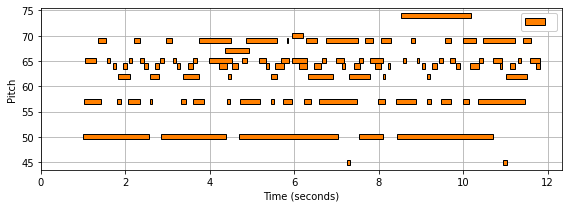

In [3]:
import libfmp.c1

midi_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.midi'
score = libfmp.c1.midi_to_list(midi_file)
libfmp.c1.visualize_piano_roll(score[:100], figsize=(8, 3))

Now, we synthesize MIDI file back to audio using Fluidsynth

In [4]:
import fluidsynth
import pretty_midi

pm = pretty_midi.PrettyMIDI(midi_file)
synth_audio = pm.fluidsynth(fs=sr)

synth_audio_seg = synth_audio[:10*sr]

ipd.Audio(synth_audio_seg, rate=sr)

The piano timbre will be different. But, it should sound pretty good.

Now, we are going to build the onsets and frames model.

## Dataloader
This cell includes data loaders and mel-spectrogram setting. We are just going to use the functions.

In [5]:

# setup the basic data configuration
SAMPLE_RATE = 16000
MIN_MIDI = 21
MAX_MIDI = 108

HOP_SIZE = 512
N_MELS = 229
N_FFT = 2048
F_MIN = 30
F_MAX = 8000


from typing import Dict, List
from torch import Tensor
from numpy import ndarray
from numpy.random.mtrand import RandomState
from pretty_midi.pretty_midi import PrettyMIDI

import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

def allocate_batch(batch:Dict[str,Tensor], device:torch.device) -> Dict[str,Tensor]:
    for key in batch.keys():
        if key != 'path':
            batch[key] = batch[key].to(device)
    return batch

class MAESTRO_small(Dataset):
    def __init__(self,
                 path:str = 'gct634-maestro',
                 groups:List[str] = None,
                 sequence_length:int = SAMPLE_RATE * 5,
                 hop_size:int = HOP_SIZE,
                 seed:int = 42,
                 random_sample:bool = True) -> None:
        self.path:str = path
        self.groups:list = groups if groups is not None else self.available_groups()
        assert all(group in self.available_groups() for group in self.groups)

        self.sample_length:int = ((sequence_length // hop_size) * hop_size) if sequence_length is not None else None
        self.random:RandomState = np.random.RandomState(seed)
        self.random_sample:bool = random_sample
        self.hop_size:int = hop_size

        self.data:List[Dict[str,Tensor]] = []

        print(f'Loading {len(groups)} group(s) of', self.__class__.__name__, 'at', path)
        for group in groups:
            file_list:List[tuple] = self.get_file_path_list_of_group(group)
            for input_files in tqdm(file_list, desc=f'Loading group {group}'):
                self.data.append(self.load(*input_files))

    @classmethod
    def available_groups(cls) -> List[str]:
        return ['train', 'validation', 'test', 'debug']

    def get_file_path_list_of_group(self, group:str) -> List[tuple]:
        metadata:List[dict] = json.load(open(os.path.join(self.path, 'data.json')))
        subset_name:str = 'train' if group == 'debug' else group

        files:List[tuple] = sorted([
                (os.path.join(self.path, row['audio_filename'].replace('.wav', '.flac')),
                 os.path.join(self.path, row['midi_filename']))
                for row in metadata if row['split'] == subset_name
            ])

        if group == 'debug':
            files = files[:10]
        else:
            files = [(audio if os.path.exists(audio) else audio.replace(
                '.flac', '.wav'), midi) for audio, midi in files]

        return files

    def load(self, audio_path:str, midi_path:str) -> Dict[str,Tensor]:
        """Loads an audio track and the corresponding labels."""
        audio, sr = soundfile.read(audio_path, dtype='int16')
        assert sr == SAMPLE_RATE

        frames_per_sec:float = sr / self.hop_size

        audio_tensor:Tensor = torch.ShortTensor(audio)
        audio_length:int = len(audio_tensor)

        midi:PrettyMIDI = pretty_midi.PrettyMIDI(midi_path)
        midi_length_sec:float = midi.get_end_time()
        frame_length:int = min(int(midi_length_sec * frames_per_sec), (audio_length // self.hop_size) + 1)

        audio_tensor = audio_tensor[:frame_length * self.hop_size]

        frame:ndarray = midi.get_piano_roll(fs=frames_per_sec)

        onset = np.zeros_like(frame)
        for inst in midi.instruments:
            for note in inst.notes:
                onset[note.pitch, int(note.start * frames_per_sec)] = 1

        # to shape (time, pitch (88))
        frame_tensor:Tensor = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
        onset_tensor:Tensor = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
        data = dict(path=audio_path, audio=audio_tensor, frame=frame_tensor, onset=onset_tensor)
        return data

    def __getitem__(self, index:int) -> Dict[str,Tensor]:
        data:Dict[str,Tensor] = self.data[index]

        audio:Tensor = data['audio']
        frames:Tensor = (data['frame'] >= 1)
        onsets:Tensor = (data['onset'] >= 1)

        frame_len:int = frames.shape[0]

        if self.sample_length is not None:
            n_steps:int = self.sample_length // self.hop_size

            step_begin:int = self.random.randint(frame_len - n_steps) if self.random_sample else 0
            step_end:int = step_begin + n_steps

            sample_begin:int = step_begin * self.hop_size
            sample_end:int = sample_begin + self.sample_length

            audio_seg:Tensor = audio[sample_begin:sample_end]
            frame_seg:Tensor = frames[step_begin:step_end]
            onset_seg:Tensor = onsets[step_begin:step_end]

            result = dict(path=data['path'])
            result['audio'] = audio_seg.float().div_(32768.0)
            result['frame'] = frame_seg.float()
            result['onset'] = onset_seg.float()
        else:
            result = dict(path=data['path'])
            result['audio'] = audio.float().div_(32768.0)
            result['frame'] = frames.float()
            result['onset'] = onsets.float()

        return result

    def __len__(self) -> int:
        return len(self.data)




## Build the Model

This cell includes neural network modules to build the onsets and frames model along with the mel-spectrogram. This is the main part that you are going to work on for this homework.

In [6]:
import random
import torch.nn as nn
import torchaudio.transforms as transforms

class LogMelSpectrogram(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspectrogram = transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_SIZE,
            f_min=F_MIN,
            f_max=F_MAX,
            n_mels=N_MELS,
            normalized=False)

    def forward(self, audio):
        # Alignment correction to match with piano roll.
        # When they convert the input into frames,
        # pretty_midi.get_piano_roll uses `ceil`,
        # but torchaudio.transforms.melspectrogram uses `round`.
        padded_audio = nn.functional.pad(audio, (HOP_SIZE // 2, 0), 'constant')
        mel = self.melspectrogram(padded_audio)[:, :, 1:]
        mel = mel.transpose(-1, -2)
        mel = torch.log(torch.clamp(mel, min=1e-9))
        return mel


class ConvStack(nn.Module):
    def __init__(self, n_mels, cnn_unit, fc_unit):
        super().__init__()

        # shape of input: (batch_size, 1 channel, frames, input_features)
        self.cnn = nn.Sequential(
            # layer 0
            nn.Conv2d(1, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 1
            nn.Conv2d(cnn_unit, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 2
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
            nn.Conv2d(cnn_unit, cnn_unit * 2, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit * 2),
            nn.ReLU(),
            # layer 3
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear((cnn_unit * 2) * (n_mels // 4), fc_unit),
            nn.Dropout(0.5))

    def forward(self, mel):
        x = mel.unsqueeze(1)
        x = self.cnn(x)
        x = x.transpose(1, 2).flatten(-2)
        x = self.fc(x)
        return x


class BiLSTM(nn.Module):
    inference_chunk_length = 512

    def __init__(self, input_features, recurrent_features):
        super().__init__()
        self.rnn = nn.LSTM(input_features, recurrent_features, batch_first=True, bidirectional=True)

    def forward(self, x):
        if self.training:
            return self.rnn(x)[0]
        else:
            # evaluation mode: support for longer sequences that do not fit in memory
            batch_size, sequence_length, input_features = x.shape
            hidden_size = self.rnn.hidden_size
            num_directions = 2 if self.rnn.bidirectional else 1

            h = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            c = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            output = torch.zeros(batch_size, sequence_length, num_directions * hidden_size, device=x.device)

            # forward direction
            slices = range(0, sequence_length, self.inference_chunk_length)
            for start in slices:
                end = start + self.inference_chunk_length
                output[:, start:end, :], (h, c) = self.rnn(x[:, start:end, :], (h, c))

            # reverse direction
            if self.rnn.bidirectional:
                h.zero_()
                c.zero_()

                for start in reversed(slices):
                    end = start + self.inference_chunk_length
                    result, (h, c) = self.rnn(x[:, start:end, :], (h, c))
                    output[:, start:end, hidden_size:] = result[:, :, hidden_size:]

            return output

class BasicOnsetsAndFrames(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        super().__init__()

        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
        mel = self.melspectrogram(audio)

        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.frame_stack(mel)  # (B, T, C)

        return frame_pred, onset_pred


class OnsetsAndFrames(nn.Module):
    def __init__(self, cnn_unit, fc_unit, rnn_unit):
        super().__init__()
        # Your part

        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            BiLSTM(fc_unit, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

        self.pre_frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.post_frame_stack = nn.Sequential(
            BiLSTM(88*2, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
        # Your part

        mel = self.melspectrogram(audio)  # (B, T, F)
        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.pre_frame_stack(mel)
        frame_pred = torch.concat((frame_pred, onset_pred), dim=2)
        frame_pred = self.post_frame_stack(frame_pred)

        return frame_pred, onset_pred


## Evaluation Functions

This cell includes evaluation functions which compute frame-level and note-level accuracy metrics. ``extract_notes'' is used to infer MIDI notes from the onset and frame predictions.

In [7]:
import argparse
from datetime import datetime
from pathlib import Path
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from collections import defaultdict
from pathlib import Path

from mido import Message, MidiFile, MidiTrack
from mir_eval.transcription import precision_recall_f1_overlap as evaluate_notes
from mir_eval.util import hz_to_midi, midi_to_hz

def cycle(iterable):
    while True:
        for item in iterable:
            yield item

def evaluate(model, batch, device, save=False, save_path=None):
    metrics = defaultdict(list)
    batch = allocate_batch(batch, device)

    frame_pred, onset_pred = model(batch['audio'])

    criterion = nn.BCELoss()
    frame_loss = criterion(frame_pred, batch['frame'])
    onset_loss = criterion(onset_pred, batch['onset'])
    metrics['metric/loss/frame_loss'].append(frame_loss.cpu().numpy())
    metrics['metric/loss/onset_loss'].append(onset_loss.cpu().numpy())

    for batch_idx in range(batch['audio'].shape[0]):
        pr, re, f1 = framewise_eval(frame_pred[batch_idx], batch['frame'][batch_idx])
        metrics['metric/frame/frame_precision'].append(pr)
        metrics['metric/frame/frame_recall'].append(re)
        metrics['metric/frame/frame_f1'].append(f1)

        pr, re, f1 = framewise_eval(onset_pred[batch_idx], batch['onset'][batch_idx])
        metrics['metric/frame/onset_precision'].append(pr)
        metrics['metric/frame/onset_recall'].append(re)
        metrics['metric/frame/onset_f1'].append(f1)

        p_est, i_est = extract_notes(onset_pred[batch_idx], frame_pred[batch_idx])
        p_ref, i_ref = extract_notes(
            batch['onset'][batch_idx], batch['frame'][batch_idx])

        scaling = HOP_SIZE / SAMPLE_RATE

        i_ref = (i_ref * scaling).reshape(-1, 2)
        p_ref = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_ref])
        i_est = (i_est * scaling).reshape(-1, 2)
        p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

        p, r, f, o = evaluate_notes(
            i_ref, p_ref, i_est, p_est, offset_ratio=None)
        metrics['metric/note/precision'].append(p)
        metrics['metric/note/recall'].append(r)
        metrics['metric/note/f1'].append(f)
        metrics['metric/note/overlap'].append(o)

        p, r, f, o = evaluate_notes(i_ref, p_ref, i_est, p_est)
        metrics['metric/note-with-offsets/precision'].append(p)
        metrics['metric/note-with-offsets/recall'].append(r)
        metrics['metric/note-with-offsets/f1'].append(f)
        metrics['metric/note-with-offsets/overlap'].append(o)

    return metrics

def framewise_eval(pred, label, threshold=0.5):
    '''Evaluates frame-wise (point-wise) evaluation.

    Args:
        pred: torch.Tensor of shape (frame, pitch)
        label: torch.Tensor of shape (frame, pitch)
    '''

    tp = torch.sum((pred >= threshold) * (label == 1)).cpu().numpy()
    fn = torch.sum((pred < threshold) * (label == 1)).cpu().numpy()
    fp = torch.sum((pred >= threshold) * (label != 1)).cpu().numpy()

    pr = tp / float(tp + fp) if (tp + fp) > 0 else 0
    re = tp / float(tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * pr * re / float(pr + re) if (pr + re) > 0 else 0

    return pr, re, f1


def extract_notes(onsets, frames, onset_threshold=0.5, frame_threshold=0.5):
    """Finds the note timings based on the onsets and frames information.

    Args:
        onsets: torch.FloatTensor of shape (frames, bins)
        frames: torch.FloatTensor of shape (frames, bins)
        onset_threshold: float
        frame_threshold: float

    Returns:
        pitches: np.ndarray of bin_indices
        intervals: np.ndarray of rows containing (onset_index, offset_index)
    """
    onsets = (onsets > onset_threshold).type(torch.int).cpu()
    frames = (frames > frame_threshold).type(torch.int).cpu()
    onset_diff = torch.cat([onsets[:1, :], onsets[1:, :] - onsets[:-1, :]],
                           dim=0) == 1

    pitches = []
    intervals = []

    for nonzero in onset_diff.nonzero():
        frame = nonzero[0].item()
        pitch = nonzero[1].item()

        onset = frame
        offset = frame

        while onsets[offset, pitch].item() or frames[offset, pitch].item():
            offset += 1
            if offset == onsets.shape[0]:
                break
            if (offset != onset) and onsets[offset, pitch].item():
                break

        if offset > onset:
            pitches.append(pitch)
            intervals.append([onset, offset])

    return np.array(pitches), np.array(intervals)

## Train and Validate the Model

This cell in the main part to train and validate the model using data loaders and an optimizer.

In [8]:
class Runner(object):
    def __init__(self, model, lr, weight_decay):
      self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
      self.scheduler = StepLR(self.optimizer, step_size=1000, gamma=0.98)
      self.learning_rate = lr
      self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
      self.model = model.to(self.device)
      self.criterion = nn.BCELoss().to(self.device)
      self.iteration = 1000

    def train(self, dataloader):

      loop = tqdm(range(1, self.iteration + 1))

      for step, batch in zip(loop, cycle(dataloader)):
        self.optimizer.zero_grad()
        batch = allocate_batch(batch, self.device)

        frame_pred, onset_pred = self.model(batch['audio'])
        frame_loss = self.criterion(frame_pred, batch['frame'])
        onset_loss = self.criterion(onset_pred, batch['onset'])
        loss = onset_loss + frame_loss

        loss.mean().backward()

        for parameter in self.model.parameters():
            clip_grad_norm_([parameter], 3.0)

        self.optimizer.step()
        self.scheduler.step()
        loop.set_postfix_str("loss: {:.3e}".format(loss.mean()))

      return loss.mean()

    def test(self, dataloader):
      self.model.eval()
      with torch.no_grad():
        metrics = defaultdict(list)
        for batch in dataloader:
          batch_results = evaluate(model, batch, self.device)

          for key, value in batch_results.items():
            metrics[key].extend(value)

      for key, value in metrics.items():
        if key[-2:] == 'f1' in key:
          print(f'{key:27} : {np.mean(value):.4f}')

      self.model.train()
      valid_loss = np.mean(metrics['metric/loss/frame_loss']+metrics['metric/loss/onset_loss'])
      return valid_loss, batch_results


Let's start training the model!

### Experiment1 : Data and Model hyperparameters

In [ ]:
batch_size = 16
iterations=3000
validation_interval=1000

sequence_lengths=[51200,102400,204800]
cnn_units=[12,24,48]
fc_units=[32,64,128]

learning_rate=1e-3
weight_decay=0

NUM_EPOCHS = 10

valid_losses = []
results = []

for sequence_length in sequence_lengths:
  train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
  valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
  
  for cnn_unit in cnn_units:
    for fc_unit in fc_units:
          
          print(f"Training with sequence_length={sequence_length}, cnn_unit={cnn_unit}, fc_unit={fc_unit}")
          
          model = BasicOnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit)
          runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

          for epoch in range(NUM_EPOCHS):
            print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
            train_loss = runner.train(train_loader)
            valid_loss, result = runner.test(valid_loader)
            valid_losses.append(valid_loss)
            results.append(result)
          print()

import pickle
with open('valid_losses.pkl', 'wb') as f:
    pickle.dump(valid_losses, f)
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


Training with sequence_length=51200, cnn_unit=12, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.97it/s, loss: 1.736e-01]
/home/airis_lab/JL/GCT634/.venv/lib/python3.10/site-packages/mir_eval/transcription.py:163: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


metric/frame/frame_f1       : 0.2118
metric/frame/onset_f1       : 0.0820
metric/note/f1              : 0.0820
metric/note-with-offsets/f1 : 0.0050
[Epoch 2/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.97it/s, loss: 1.633e-01]


metric/frame/frame_f1       : 0.2970
metric/frame/onset_f1       : 0.2696
metric/note/f1              : 0.2888
metric/note-with-offsets/f1 : 0.0910
[Epoch 3/10]


100%|██████████| 1000/1000 [00:19<00:00, 52.18it/s, loss: 1.877e-01]


metric/frame/frame_f1       : 0.4056
metric/frame/onset_f1       : 0.2385
metric/note/f1              : 0.2661
metric/note-with-offsets/f1 : 0.0703
[Epoch 4/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.85it/s, loss: 1.645e-01]


metric/frame/frame_f1       : 0.2780
metric/frame/onset_f1       : 0.2387
metric/note/f1              : 0.2642
metric/note-with-offsets/f1 : 0.0542
[Epoch 5/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s, loss: 1.751e-01]


metric/frame/frame_f1       : 0.5122
metric/frame/onset_f1       : 0.2613
metric/note/f1              : 0.2802
metric/note-with-offsets/f1 : 0.1332
[Epoch 6/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.33it/s, loss: 2.156e-01]


metric/frame/frame_f1       : 0.3166
metric/frame/onset_f1       : 0.2614
metric/note/f1              : 0.2854
metric/note-with-offsets/f1 : 0.0754
[Epoch 7/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.68it/s, loss: 1.553e-01]


metric/frame/frame_f1       : 0.4233
metric/frame/onset_f1       : 0.2770
metric/note/f1              : 0.3018
metric/note-with-offsets/f1 : 0.1040
[Epoch 8/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.08it/s, loss: 1.562e-01]


metric/frame/frame_f1       : 0.3584
metric/frame/onset_f1       : 0.2855
metric/note/f1              : 0.3126
metric/note-with-offsets/f1 : 0.0504
[Epoch 9/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.69it/s, loss: 2.152e-01]


metric/frame/frame_f1       : 0.3272
metric/frame/onset_f1       : 0.3057
metric/note/f1              : 0.3260
metric/note-with-offsets/f1 : 0.0760
[Epoch 10/10]


100%|██████████| 1000/1000 [00:19<00:00, 52.48it/s, loss: 1.969e-01]


metric/frame/frame_f1       : 0.3975
metric/frame/onset_f1       : 0.3059
metric/note/f1              : 0.3205
metric/note-with-offsets/f1 : 0.1289

Training with sequence_length=51200, cnn_unit=12, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.20it/s, loss: 1.900e-01]


metric/frame/frame_f1       : 0.5249
metric/frame/onset_f1       : 0.3735
metric/note/f1              : 0.3957
metric/note-with-offsets/f1 : 0.1631
[Epoch 2/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.06it/s, loss: 1.738e-01]


metric/frame/frame_f1       : 0.5735
metric/frame/onset_f1       : 0.5356
metric/note/f1              : 0.5763
metric/note-with-offsets/f1 : 0.3265
[Epoch 3/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.60it/s, loss: 2.002e-01]


metric/frame/frame_f1       : 0.5337
metric/frame/onset_f1       : 0.5647
metric/note/f1              : 0.6410
metric/note-with-offsets/f1 : 0.2734
[Epoch 4/10]


100%|██████████| 1000/1000 [00:20<00:00, 49.95it/s, loss: 1.743e-01]


metric/frame/frame_f1       : 0.5827
metric/frame/onset_f1       : 0.5386
metric/note/f1              : 0.5911
metric/note-with-offsets/f1 : 0.2896
[Epoch 5/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.67it/s, loss: 1.555e-01]


metric/frame/frame_f1       : 0.5682
metric/frame/onset_f1       : 0.6126
metric/note/f1              : 0.6660
metric/note-with-offsets/f1 : 0.2815
[Epoch 6/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.41it/s, loss: 2.075e-01]


metric/frame/frame_f1       : 0.5786
metric/frame/onset_f1       : 0.6385
metric/note/f1              : 0.7494
metric/note-with-offsets/f1 : 0.2507
[Epoch 7/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s, loss: 1.961e-01]


metric/frame/frame_f1       : 0.5641
metric/frame/onset_f1       : 0.6057
metric/note/f1              : 0.6654
metric/note-with-offsets/f1 : 0.2699
[Epoch 8/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.98it/s, loss: 1.434e-01]


metric/frame/frame_f1       : 0.6195
metric/frame/onset_f1       : 0.5924
metric/note/f1              : 0.6378
metric/note-with-offsets/f1 : 0.3483
[Epoch 9/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.10it/s, loss: 1.460e-01]


metric/frame/frame_f1       : 0.6248
metric/frame/onset_f1       : 0.6365
metric/note/f1              : 0.6920
metric/note-with-offsets/f1 : 0.3565
[Epoch 10/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.53it/s, loss: 1.341e-01]


metric/frame/frame_f1       : 0.6389
metric/frame/onset_f1       : 0.6549
metric/note/f1              : 0.7217
metric/note-with-offsets/f1 : 0.3890

Training with sequence_length=51200, cnn_unit=12, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.34it/s, loss: 2.049e-01]


metric/frame/frame_f1       : 0.5602
metric/frame/onset_f1       : 0.4924
metric/note/f1              : 0.5298
metric/note-with-offsets/f1 : 0.2749
[Epoch 2/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s, loss: 1.654e-01]


metric/frame/frame_f1       : 0.6672
metric/frame/onset_f1       : 0.5603
metric/note/f1              : 0.5981
metric/note-with-offsets/f1 : 0.3834
[Epoch 3/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.27it/s, loss: 1.387e-01]


metric/frame/frame_f1       : 0.6585
metric/frame/onset_f1       : 0.6013
metric/note/f1              : 0.6694
metric/note-with-offsets/f1 : 0.4220
[Epoch 4/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.19it/s, loss: 1.433e-01]


metric/frame/frame_f1       : 0.6650
metric/frame/onset_f1       : 0.6580
metric/note/f1              : 0.7533
metric/note-with-offsets/f1 : 0.4064
[Epoch 5/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.76it/s, loss: 1.139e-01]


metric/frame/frame_f1       : 0.6683
metric/frame/onset_f1       : 0.6216
metric/note/f1              : 0.6727
metric/note-with-offsets/f1 : 0.4258
[Epoch 6/10]


100%|██████████| 1000/1000 [00:19<00:00, 51.04it/s, loss: 1.086e-01]


metric/frame/frame_f1       : 0.6585
metric/frame/onset_f1       : 0.6452
metric/note/f1              : 0.7471
metric/note-with-offsets/f1 : 0.3723
[Epoch 7/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.05it/s, loss: 1.510e-01]


metric/frame/frame_f1       : 0.6922
metric/frame/onset_f1       : 0.6179
metric/note/f1              : 0.7075
metric/note-with-offsets/f1 : 0.4037
[Epoch 8/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.65it/s, loss: 1.002e-01]


metric/frame/frame_f1       : 0.6850
metric/frame/onset_f1       : 0.6447
metric/note/f1              : 0.7250
metric/note-with-offsets/f1 : 0.3912
[Epoch 9/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.85it/s, loss: 1.601e-01]


metric/frame/frame_f1       : 0.7095
metric/frame/onset_f1       : 0.6450
metric/note/f1              : 0.7360
metric/note-with-offsets/f1 : 0.4240
[Epoch 10/10]


100%|██████████| 1000/1000 [00:19<00:00, 50.35it/s, loss: 1.429e-01]


metric/frame/frame_f1       : 0.7302
metric/frame/onset_f1       : 0.6836
metric/note/f1              : 0.7469
metric/note-with-offsets/f1 : 0.4616

Training with sequence_length=51200, cnn_unit=24, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:21<00:00, 46.00it/s, loss: 2.308e-01]


metric/frame/frame_f1       : 0.3887
metric/frame/onset_f1       : 0.0975
metric/note/f1              : 0.0975
metric/note-with-offsets/f1 : 0.0446
[Epoch 2/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.92it/s, loss: 1.826e-01]


metric/frame/frame_f1       : 0.2291
metric/frame/onset_f1       : 0.2176
metric/note/f1              : 0.2352
metric/note-with-offsets/f1 : 0.0574
[Epoch 3/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.87it/s, loss: 1.597e-01]


metric/frame/frame_f1       : 0.3734
metric/frame/onset_f1       : 0.3224
metric/note/f1              : 0.3421
metric/note-with-offsets/f1 : 0.1506
[Epoch 4/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s, loss: 1.756e-01]


metric/frame/frame_f1       : 0.4262
metric/frame/onset_f1       : 0.3363
metric/note/f1              : 0.3699
metric/note-with-offsets/f1 : 0.1095
[Epoch 5/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.88it/s, loss: 2.087e-01]


metric/frame/frame_f1       : 0.4234
metric/frame/onset_f1       : 0.4310
metric/note/f1              : 0.4565
metric/note-with-offsets/f1 : 0.1506
[Epoch 6/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.90it/s, loss: 2.232e-01]


metric/frame/frame_f1       : 0.0881
metric/frame/onset_f1       : 0.4946
metric/note/f1              : 0.5323
metric/note-with-offsets/f1 : 0.0447
[Epoch 7/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.54it/s, loss: 1.797e-01]


metric/frame/frame_f1       : 0.3874
metric/frame/onset_f1       : 0.4456
metric/note/f1              : 0.4734
metric/note-with-offsets/f1 : 0.1356
[Epoch 8/10]


100%|██████████| 1000/1000 [00:21<00:00, 46.12it/s, loss: 1.612e-01]


metric/frame/frame_f1       : 0.4555
metric/frame/onset_f1       : 0.4500
metric/note/f1              : 0.4787
metric/note-with-offsets/f1 : 0.1365
[Epoch 9/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.86it/s, loss: 1.465e-01]


metric/frame/frame_f1       : 0.4166
metric/frame/onset_f1       : 0.3528
metric/note/f1              : 0.3809
metric/note-with-offsets/f1 : 0.1380
[Epoch 10/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.48it/s, loss: 1.681e-01]


metric/frame/frame_f1       : 0.2875
metric/frame/onset_f1       : 0.3881
metric/note/f1              : 0.4038
metric/note-with-offsets/f1 : 0.1027

Training with sequence_length=51200, cnn_unit=24, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.40it/s, loss: 1.453e-01]


metric/frame/frame_f1       : 0.5888
metric/frame/onset_f1       : 0.4018
metric/note/f1              : 0.4335
metric/note-with-offsets/f1 : 0.2130
[Epoch 2/10]


100%|██████████| 1000/1000 [00:21<00:00, 46.02it/s, loss: 1.507e-01]


metric/frame/frame_f1       : 0.5899
metric/frame/onset_f1       : 0.4670
metric/note/f1              : 0.5024
metric/note-with-offsets/f1 : 0.2942
[Epoch 3/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.91it/s, loss: 1.788e-01]


metric/frame/frame_f1       : 0.5975
metric/frame/onset_f1       : 0.6079
metric/note/f1              : 0.6738
metric/note-with-offsets/f1 : 0.2887
[Epoch 4/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s, loss: 1.307e-01]


metric/frame/frame_f1       : 0.6361
metric/frame/onset_f1       : 0.5954
metric/note/f1              : 0.6648
metric/note-with-offsets/f1 : 0.3243
[Epoch 5/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.82it/s, loss: 1.554e-01]


metric/frame/frame_f1       : 0.5903
metric/frame/onset_f1       : 0.6348
metric/note/f1              : 0.6760
metric/note-with-offsets/f1 : 0.3949
[Epoch 6/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.83it/s, loss: 1.437e-01]


metric/frame/frame_f1       : 0.6314
metric/frame/onset_f1       : 0.6624
metric/note/f1              : 0.7447
metric/note-with-offsets/f1 : 0.3817
[Epoch 7/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.85it/s, loss: 1.518e-01]


metric/frame/frame_f1       : 0.6523
metric/frame/onset_f1       : 0.6686
metric/note/f1              : 0.7641
metric/note-with-offsets/f1 : 0.3787
[Epoch 8/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.58it/s, loss: 1.233e-01]


metric/frame/frame_f1       : 0.6520
metric/frame/onset_f1       : 0.6567
metric/note/f1              : 0.7184
metric/note-with-offsets/f1 : 0.3955
[Epoch 9/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.68it/s, loss: 1.568e-01]


metric/frame/frame_f1       : 0.6413
metric/frame/onset_f1       : 0.6564
metric/note/f1              : 0.7370
metric/note-with-offsets/f1 : 0.3717
[Epoch 10/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.80it/s, loss: 1.207e-01]


metric/frame/frame_f1       : 0.6407
metric/frame/onset_f1       : 0.6644
metric/note/f1              : 0.7498
metric/note-with-offsets/f1 : 0.3583

Training with sequence_length=51200, cnn_unit=24, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.23it/s, loss: 1.617e-01]


metric/frame/frame_f1       : 0.6654
metric/frame/onset_f1       : 0.4816
metric/note/f1              : 0.5403
metric/note-with-offsets/f1 : 0.2833
[Epoch 2/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.09it/s, loss: 1.404e-01]


metric/frame/frame_f1       : 0.5927
metric/frame/onset_f1       : 0.6510
metric/note/f1              : 0.7539
metric/note-with-offsets/f1 : 0.2110
[Epoch 3/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.28it/s, loss: 1.603e-01]


metric/frame/frame_f1       : 0.6967
metric/frame/onset_f1       : 0.6500
metric/note/f1              : 0.7482
metric/note-with-offsets/f1 : 0.3308
[Epoch 4/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.56it/s, loss: 1.474e-01]


metric/frame/frame_f1       : 0.7135
metric/frame/onset_f1       : 0.6599
metric/note/f1              : 0.7374
metric/note-with-offsets/f1 : 0.4392
[Epoch 5/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.51it/s, loss: 1.308e-01]


metric/frame/frame_f1       : 0.6898
metric/frame/onset_f1       : 0.6916
metric/note/f1              : 0.7790
metric/note-with-offsets/f1 : 0.3728
[Epoch 6/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.70it/s, loss: 1.317e-01]


metric/frame/frame_f1       : 0.7283
metric/frame/onset_f1       : 0.7022
metric/note/f1              : 0.7867
metric/note-with-offsets/f1 : 0.5005
[Epoch 7/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.28it/s, loss: 9.539e-02]


metric/frame/frame_f1       : 0.7078
metric/frame/onset_f1       : 0.6981
metric/note/f1              : 0.7809
metric/note-with-offsets/f1 : 0.4339
[Epoch 8/10]


100%|██████████| 1000/1000 [00:22<00:00, 45.43it/s, loss: 1.221e-01]


metric/frame/frame_f1       : 0.7695
metric/frame/onset_f1       : 0.6931
metric/note/f1              : 0.7755
metric/note-with-offsets/f1 : 0.4691
[Epoch 9/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.60it/s, loss: 1.075e-01]


metric/frame/frame_f1       : 0.7775
metric/frame/onset_f1       : 0.6951
metric/note/f1              : 0.7774
metric/note-with-offsets/f1 : 0.4937
[Epoch 10/10]


100%|██████████| 1000/1000 [00:21<00:00, 45.50it/s, loss: 1.465e-01]


metric/frame/frame_f1       : 0.7412
metric/frame/onset_f1       : 0.6934
metric/note/f1              : 0.7667
metric/note-with-offsets/f1 : 0.4854

Training with sequence_length=51200, cnn_unit=48, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s, loss: 2.143e-01]


metric/frame/frame_f1       : 0.1718
metric/frame/onset_f1       : 0.1020
metric/note/f1              : 0.1020
metric/note-with-offsets/f1 : 0.0120
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.93it/s, loss: 1.528e-01]


metric/frame/frame_f1       : 0.3831
metric/frame/onset_f1       : 0.2825
metric/note/f1              : 0.2918
metric/note-with-offsets/f1 : 0.1169
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 1.719e-01]


metric/frame/frame_f1       : 0.2760
metric/frame/onset_f1       : 0.2606
metric/note/f1              : 0.2648
metric/note-with-offsets/f1 : 0.0525
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.02it/s, loss: 1.783e-01]


metric/frame/frame_f1       : 0.2670
metric/frame/onset_f1       : 0.4203
metric/note/f1              : 0.4364
metric/note-with-offsets/f1 : 0.0695
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s, loss: 1.588e-01]


metric/frame/frame_f1       : 0.2738
metric/frame/onset_f1       : 0.5056
metric/note/f1              : 0.5359
metric/note-with-offsets/f1 : 0.0676
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 2.136e-01]


metric/frame/frame_f1       : 0.4124
metric/frame/onset_f1       : 0.3319
metric/note/f1              : 0.3493
metric/note-with-offsets/f1 : 0.1082
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s, loss: 1.843e-01]


metric/frame/frame_f1       : 0.4619
metric/frame/onset_f1       : 0.3700
metric/note/f1              : 0.3899
metric/note-with-offsets/f1 : 0.1747
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 1.224e-01]


metric/frame/frame_f1       : 0.3242
metric/frame/onset_f1       : 0.3616
metric/note/f1              : 0.3875
metric/note-with-offsets/f1 : 0.1003
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.05it/s, loss: 1.567e-01]


metric/frame/frame_f1       : 0.4225
metric/frame/onset_f1       : 0.5463
metric/note/f1              : 0.5874
metric/note-with-offsets/f1 : 0.1555
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s, loss: 1.604e-01]


metric/frame/frame_f1       : 0.4209
metric/frame/onset_f1       : 0.4832
metric/note/f1              : 0.5092
metric/note-with-offsets/f1 : 0.1386

Training with sequence_length=51200, cnn_unit=48, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 1.723e-01]


metric/frame/frame_f1       : 0.4830
metric/frame/onset_f1       : 0.3171
metric/note/f1              : 0.3257
metric/note-with-offsets/f1 : 0.1106
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.95it/s, loss: 1.781e-01]


metric/frame/frame_f1       : 0.6038
metric/frame/onset_f1       : 0.6285
metric/note/f1              : 0.6830
metric/note-with-offsets/f1 : 0.3201
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.91it/s, loss: 1.113e-01]


metric/frame/frame_f1       : 0.6365
metric/frame/onset_f1       : 0.6309
metric/note/f1              : 0.6944
metric/note-with-offsets/f1 : 0.3247
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s, loss: 2.218e-01]


metric/frame/frame_f1       : 0.6728
metric/frame/onset_f1       : 0.5789
metric/note/f1              : 0.6158
metric/note-with-offsets/f1 : 0.3978
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s, loss: 1.677e-01]


metric/frame/frame_f1       : 0.6643
metric/frame/onset_f1       : 0.6537
metric/note/f1              : 0.7306
metric/note-with-offsets/f1 : 0.4201
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s, loss: 1.280e-01]


metric/frame/frame_f1       : 0.6437
metric/frame/onset_f1       : 0.6718
metric/note/f1              : 0.7493
metric/note-with-offsets/f1 : 0.3806
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s, loss: 1.004e-01]


metric/frame/frame_f1       : 0.6711
metric/frame/onset_f1       : 0.6870
metric/note/f1              : 0.7616
metric/note-with-offsets/f1 : 0.4357
[Epoch 8/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.367e-01]


metric/frame/frame_f1       : 0.6291
metric/frame/onset_f1       : 0.7036
metric/note/f1              : 0.7703
metric/note-with-offsets/f1 : 0.3832
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.90it/s, loss: 1.344e-01]


metric/frame/frame_f1       : 0.7147
metric/frame/onset_f1       : 0.6867
metric/note/f1              : 0.7453
metric/note-with-offsets/f1 : 0.4814
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 1.397e-01]


metric/frame/frame_f1       : 0.6739
metric/frame/onset_f1       : 0.7134
metric/note/f1              : 0.7698
metric/note-with-offsets/f1 : 0.4615

Training with sequence_length=51200, cnn_unit=48, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.85it/s, loss: 1.587e-01]


metric/frame/frame_f1       : 0.6518
metric/frame/onset_f1       : 0.5987
metric/note/f1              : 0.6689
metric/note-with-offsets/f1 : 0.3450
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s, loss: 1.445e-01]


metric/frame/frame_f1       : 0.6542
metric/frame/onset_f1       : 0.6503
metric/note/f1              : 0.7286
metric/note-with-offsets/f1 : 0.3918
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.76it/s, loss: 1.065e-01]


metric/frame/frame_f1       : 0.7021
metric/frame/onset_f1       : 0.6914
metric/note/f1              : 0.7925
metric/note-with-offsets/f1 : 0.4131
[Epoch 4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.217e-01]


metric/frame/frame_f1       : 0.7235
metric/frame/onset_f1       : 0.7101
metric/note/f1              : 0.7877
metric/note-with-offsets/f1 : 0.4735
[Epoch 5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.001e-01]


metric/frame/frame_f1       : 0.7244
metric/frame/onset_f1       : 0.7188
metric/note/f1              : 0.7995
metric/note-with-offsets/f1 : 0.4355
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.79it/s, loss: 1.375e-01]


metric/frame/frame_f1       : 0.6830
metric/frame/onset_f1       : 0.7078
metric/note/f1              : 0.7828
metric/note-with-offsets/f1 : 0.4347
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 1.125e-01]


metric/frame/frame_f1       : 0.7697
metric/frame/onset_f1       : 0.7087
metric/note/f1              : 0.7653
metric/note-with-offsets/f1 : 0.4865
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.81it/s, loss: 1.002e-01]


metric/frame/frame_f1       : 0.7325
metric/frame/onset_f1       : 0.7146
metric/note/f1              : 0.7744
metric/note-with-offsets/f1 : 0.4612
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.78it/s, loss: 1.286e-01]


metric/frame/frame_f1       : 0.7316
metric/frame/onset_f1       : 0.7158
metric/note/f1              : 0.8426
metric/note-with-offsets/f1 : 0.3648
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 1.275e-01]


metric/frame/frame_f1       : 0.7744
metric/frame/onset_f1       : 0.7370
metric/note/f1              : 0.8130
metric/note-with-offsets/f1 : 0.4962

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


Training with sequence_length=102400, cnn_unit=12, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.75it/s, loss: 2.790e-01]


metric/frame/frame_f1       : 0.3537
metric/frame/onset_f1       : 0.0130
metric/note/f1              : 0.0130
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.64it/s, loss: 1.847e-01]


metric/frame/frame_f1       : 0.2346
metric/frame/onset_f1       : 0.2362
metric/note/f1              : 0.2469
metric/note-with-offsets/f1 : 0.0473
[Epoch 3/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.64it/s, loss: 2.159e-01]


metric/frame/frame_f1       : 0.3278
metric/frame/onset_f1       : 0.2800
metric/note/f1              : 0.2957
metric/note-with-offsets/f1 : 0.0671
[Epoch 4/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.57it/s, loss: 2.361e-01]


metric/frame/frame_f1       : 0.4067
metric/frame/onset_f1       : 0.3677
metric/note/f1              : 0.3955
metric/note-with-offsets/f1 : 0.0930
[Epoch 5/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.75it/s, loss: 2.393e-01]


metric/frame/frame_f1       : 0.3316
metric/frame/onset_f1       : 0.4341
metric/note/f1              : 0.4778
metric/note-with-offsets/f1 : 0.0775
[Epoch 6/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.77it/s, loss: 1.624e-01]


metric/frame/frame_f1       : 0.4294
metric/frame/onset_f1       : 0.2468
metric/note/f1              : 0.2644
metric/note-with-offsets/f1 : 0.0585
[Epoch 7/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.61it/s, loss: 1.534e-01]


metric/frame/frame_f1       : 0.4394
metric/frame/onset_f1       : 0.3317
metric/note/f1              : 0.3627
metric/note-with-offsets/f1 : 0.0848
[Epoch 8/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.64it/s, loss: 1.850e-01]


metric/frame/frame_f1       : 0.4675
metric/frame/onset_f1       : 0.4327
metric/note/f1              : 0.4764
metric/note-with-offsets/f1 : 0.1299
[Epoch 9/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.80it/s, loss: 2.099e-01]


metric/frame/frame_f1       : 0.3865
metric/frame/onset_f1       : 0.3832
metric/note/f1              : 0.4188
metric/note-with-offsets/f1 : 0.0660
[Epoch 10/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.71it/s, loss: 1.633e-01]


metric/frame/frame_f1       : 0.4012
metric/frame/onset_f1       : 0.3980
metric/note/f1              : 0.4303
metric/note-with-offsets/f1 : 0.0960

Training with sequence_length=102400, cnn_unit=12, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s, loss: 1.639e-01]


metric/frame/frame_f1       : 0.4678
metric/frame/onset_f1       : 0.3595
metric/note/f1              : 0.3867
metric/note-with-offsets/f1 : 0.1003
[Epoch 2/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s, loss: 1.627e-01]


metric/frame/frame_f1       : 0.5354
metric/frame/onset_f1       : 0.5469
metric/note/f1              : 0.6091
metric/note-with-offsets/f1 : 0.2037
[Epoch 3/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.55it/s, loss: 1.441e-01]


metric/frame/frame_f1       : 0.4977
metric/frame/onset_f1       : 0.5869
metric/note/f1              : 0.6663
metric/note-with-offsets/f1 : 0.1850
[Epoch 4/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s, loss: 1.184e-01]


metric/frame/frame_f1       : 0.5321
metric/frame/onset_f1       : 0.5778
metric/note/f1              : 0.6593
metric/note-with-offsets/f1 : 0.1905
[Epoch 5/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s, loss: 1.748e-01]


metric/frame/frame_f1       : 0.5488
metric/frame/onset_f1       : 0.5683
metric/note/f1              : 0.6394
metric/note-with-offsets/f1 : 0.1960
[Epoch 6/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s, loss: 1.571e-01]


metric/frame/frame_f1       : 0.6055
metric/frame/onset_f1       : 0.5298
metric/note/f1              : 0.5915
metric/note-with-offsets/f1 : 0.2389
[Epoch 7/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s, loss: 1.557e-01]


metric/frame/frame_f1       : 0.5759
metric/frame/onset_f1       : 0.6381
metric/note/f1              : 0.7181
metric/note-with-offsets/f1 : 0.2392
[Epoch 8/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s, loss: 1.913e-01]


metric/frame/frame_f1       : 0.5874
metric/frame/onset_f1       : 0.6270
metric/note/f1              : 0.7051
metric/note-with-offsets/f1 : 0.2575
[Epoch 9/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.38it/s, loss: 1.358e-01]


metric/frame/frame_f1       : 0.5621
metric/frame/onset_f1       : 0.6315
metric/note/f1              : 0.7077
metric/note-with-offsets/f1 : 0.2328
[Epoch 10/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s, loss: 2.191e-01]


metric/frame/frame_f1       : 0.6271
metric/frame/onset_f1       : 0.6366
metric/note/f1              : 0.7151
metric/note-with-offsets/f1 : 0.3074

Training with sequence_length=102400, cnn_unit=12, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.32it/s, loss: 1.600e-01]


metric/frame/frame_f1       : 0.5860
metric/frame/onset_f1       : 0.5350
metric/note/f1              : 0.5878
metric/note-with-offsets/f1 : 0.2221
[Epoch 2/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.23it/s, loss: 1.621e-01]


metric/frame/frame_f1       : 0.6119
metric/frame/onset_f1       : 0.5762
metric/note/f1              : 0.6616
metric/note-with-offsets/f1 : 0.2575
[Epoch 3/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.37it/s, loss: 1.589e-01]


metric/frame/frame_f1       : 0.6489
metric/frame/onset_f1       : 0.6161
metric/note/f1              : 0.7028
metric/note-with-offsets/f1 : 0.2982
[Epoch 4/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s, loss: 1.340e-01]


metric/frame/frame_f1       : 0.6475
metric/frame/onset_f1       : 0.6241
metric/note/f1              : 0.7125
metric/note-with-offsets/f1 : 0.3348
[Epoch 5/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.27it/s, loss: 1.153e-01]


metric/frame/frame_f1       : 0.6076
metric/frame/onset_f1       : 0.6240
metric/note/f1              : 0.7036
metric/note-with-offsets/f1 : 0.2741
[Epoch 6/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s, loss: 1.434e-01]


metric/frame/frame_f1       : 0.6591
metric/frame/onset_f1       : 0.6291
metric/note/f1              : 0.7259
metric/note-with-offsets/f1 : 0.3463
[Epoch 7/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.20it/s, loss: 1.061e-01]


metric/frame/frame_f1       : 0.6643
metric/frame/onset_f1       : 0.6774
metric/note/f1              : 0.7820
metric/note-with-offsets/f1 : 0.2992
[Epoch 8/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s, loss: 1.159e-01]


metric/frame/frame_f1       : 0.6561
metric/frame/onset_f1       : 0.6620
metric/note/f1              : 0.7663
metric/note-with-offsets/f1 : 0.2963
[Epoch 9/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.23it/s, loss: 1.123e-01]


metric/frame/frame_f1       : 0.6826
metric/frame/onset_f1       : 0.6437
metric/note/f1              : 0.7301
metric/note-with-offsets/f1 : 0.3624
[Epoch 10/10]


100%|██████████| 1000/1000 [00:25<00:00, 39.34it/s, loss: 1.597e-01]


metric/frame/frame_f1       : 0.6897
metric/frame/onset_f1       : 0.6592
metric/note/f1              : 0.7478
metric/note-with-offsets/f1 : 0.3175

Training with sequence_length=102400, cnn_unit=24, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 2.215e-01]


metric/frame/frame_f1       : 0.2651
metric/frame/onset_f1       : 0.0747
metric/note/f1              : 0.0747
metric/note-with-offsets/f1 : 0.0191
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.22it/s, loss: 2.002e-01]


metric/frame/frame_f1       : 0.2406
metric/frame/onset_f1       : 0.3133
metric/note/f1              : 0.3373
metric/note-with-offsets/f1 : 0.0506
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s, loss: 1.550e-01]


metric/frame/frame_f1       : 0.4060
metric/frame/onset_f1       : 0.1405
metric/note/f1              : 0.1405
metric/note-with-offsets/f1 : 0.0307
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s, loss: 1.464e-01]


metric/frame/frame_f1       : 0.3356
metric/frame/onset_f1       : 0.3891
metric/note/f1              : 0.4258
metric/note-with-offsets/f1 : 0.0742
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s, loss: 1.776e-01]


metric/frame/frame_f1       : 0.3619
metric/frame/onset_f1       : 0.2333
metric/note/f1              : 0.2408
metric/note-with-offsets/f1 : 0.0537
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s, loss: 1.630e-01]


metric/frame/frame_f1       : 0.4301
metric/frame/onset_f1       : 0.3903
metric/note/f1              : 0.4222
metric/note-with-offsets/f1 : 0.1010
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.25it/s, loss: 2.295e-01]


metric/frame/frame_f1       : 0.4795
metric/frame/onset_f1       : 0.2946
metric/note/f1              : 0.3172
metric/note-with-offsets/f1 : 0.1070
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s, loss: 1.790e-01]


metric/frame/frame_f1       : 0.4553
metric/frame/onset_f1       : 0.4797
metric/note/f1              : 0.5231
metric/note-with-offsets/f1 : 0.1278
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.15it/s, loss: 1.511e-01]


metric/frame/frame_f1       : 0.3867
metric/frame/onset_f1       : 0.4247
metric/note/f1              : 0.4655
metric/note-with-offsets/f1 : 0.0911
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s, loss: 1.845e-01]


metric/frame/frame_f1       : 0.5134
metric/frame/onset_f1       : 0.5016
metric/note/f1              : 0.5469
metric/note-with-offsets/f1 : 0.1794

Training with sequence_length=102400, cnn_unit=24, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s, loss: 1.696e-01]


metric/frame/frame_f1       : 0.5360
metric/frame/onset_f1       : 0.4750
metric/note/f1              : 0.5166
metric/note-with-offsets/f1 : 0.2071
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.16it/s, loss: 1.551e-01]


metric/frame/frame_f1       : 0.5944
metric/frame/onset_f1       : 0.5532
metric/note/f1              : 0.6166
metric/note-with-offsets/f1 : 0.2907
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s, loss: 1.524e-01]


metric/frame/frame_f1       : 0.6123
metric/frame/onset_f1       : 0.6329
metric/note/f1              : 0.7115
metric/note-with-offsets/f1 : 0.2701
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.18it/s, loss: 1.332e-01]


metric/frame/frame_f1       : 0.6119
metric/frame/onset_f1       : 0.6353
metric/note/f1              : 0.7116
metric/note-with-offsets/f1 : 0.2684
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s, loss: 1.368e-01]


metric/frame/frame_f1       : 0.6108
metric/frame/onset_f1       : 0.6562
metric/note/f1              : 0.7341
metric/note-with-offsets/f1 : 0.2794
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.22it/s, loss: 1.402e-01]


metric/frame/frame_f1       : 0.6344
metric/frame/onset_f1       : 0.6504
metric/note/f1              : 0.7370
metric/note-with-offsets/f1 : 0.3207
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.18it/s, loss: 9.629e-02]


metric/frame/frame_f1       : 0.5449
metric/frame/onset_f1       : 0.6414
metric/note/f1              : 0.7231
metric/note-with-offsets/f1 : 0.2341
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.18it/s, loss: 2.328e-01]


metric/frame/frame_f1       : 0.5856
metric/frame/onset_f1       : 0.6440
metric/note/f1              : 0.7159
metric/note-with-offsets/f1 : 0.2953
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s, loss: 1.551e-01]


metric/frame/frame_f1       : 0.6250
metric/frame/onset_f1       : 0.6816
metric/note/f1              : 0.7766
metric/note-with-offsets/f1 : 0.2932
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.18it/s, loss: 1.370e-01]


metric/frame/frame_f1       : 0.6405
metric/frame/onset_f1       : 0.6609
metric/note/f1              : 0.7467
metric/note-with-offsets/f1 : 0.3112

Training with sequence_length=102400, cnn_unit=24, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 1.371e-01]


metric/frame/frame_f1       : 0.4627
metric/frame/onset_f1       : 0.5819
metric/note/f1              : 0.6394
metric/note-with-offsets/f1 : 0.1372
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 1.036e-01]


metric/frame/frame_f1       : 0.6568
metric/frame/onset_f1       : 0.6165
metric/note/f1              : 0.6917
metric/note-with-offsets/f1 : 0.3137
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.06it/s, loss: 1.503e-01]


metric/frame/frame_f1       : 0.6690
metric/frame/onset_f1       : 0.6524
metric/note/f1              : 0.7261
metric/note-with-offsets/f1 : 0.3430
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.04it/s, loss: 1.331e-01]


metric/frame/frame_f1       : 0.6528
metric/frame/onset_f1       : 0.6871
metric/note/f1              : 0.7958
metric/note-with-offsets/f1 : 0.3027
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.05it/s, loss: 1.485e-01]


metric/frame/frame_f1       : 0.6736
metric/frame/onset_f1       : 0.6979
metric/note/f1              : 0.7812
metric/note-with-offsets/f1 : 0.3052
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 1.218e-01]


metric/frame/frame_f1       : 0.7024
metric/frame/onset_f1       : 0.6972
metric/note/f1              : 0.8006
metric/note-with-offsets/f1 : 0.3685
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.03it/s, loss: 1.090e-01]


metric/frame/frame_f1       : 0.6786
metric/frame/onset_f1       : 0.6980
metric/note/f1              : 0.7836
metric/note-with-offsets/f1 : 0.3576
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.04it/s, loss: 1.590e-01]


metric/frame/frame_f1       : 0.6915
metric/frame/onset_f1       : 0.7092
metric/note/f1              : 0.8085
metric/note-with-offsets/f1 : 0.3764
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s, loss: 1.012e-01]


metric/frame/frame_f1       : 0.6618
metric/frame/onset_f1       : 0.7146
metric/note/f1              : 0.8186
metric/note-with-offsets/f1 : 0.3296
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.01it/s, loss: 1.124e-01]


metric/frame/frame_f1       : 0.7150
metric/frame/onset_f1       : 0.6976
metric/note/f1              : 0.8030
metric/note-with-offsets/f1 : 0.4027

Training with sequence_length=102400, cnn_unit=48, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.863e-01]


metric/frame/frame_f1       : 0.2707
metric/frame/onset_f1       : 0.1361
metric/note/f1              : 0.1398
metric/note-with-offsets/f1 : 0.0360
[Epoch 2/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s, loss: 2.638e-01]


metric/frame/frame_f1       : 0.3484
metric/frame/onset_f1       : 0.2024
metric/note/f1              : 0.2128
metric/note-with-offsets/f1 : 0.0508
[Epoch 3/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.607e-01]


metric/frame/frame_f1       : 0.3612
metric/frame/onset_f1       : 0.2755
metric/note/f1              : 0.2833
metric/note-with-offsets/f1 : 0.0631
[Epoch 4/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s, loss: 1.630e-01]


metric/frame/frame_f1       : 0.4440
metric/frame/onset_f1       : 0.3216
metric/note/f1              : 0.3501
metric/note-with-offsets/f1 : 0.0992
[Epoch 5/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.58it/s, loss: 1.807e-01]


metric/frame/frame_f1       : 0.4634
metric/frame/onset_f1       : 0.5105
metric/note/f1              : 0.5567
metric/note-with-offsets/f1 : 0.1582
[Epoch 6/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.56it/s, loss: 1.643e-01]


metric/frame/frame_f1       : 0.4186
metric/frame/onset_f1       : 0.4320
metric/note/f1              : 0.4691
metric/note-with-offsets/f1 : 0.1046
[Epoch 7/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.56it/s, loss: 1.275e-01]


metric/frame/frame_f1       : 0.4328
metric/frame/onset_f1       : 0.4827
metric/note/f1              : 0.5250
metric/note-with-offsets/f1 : 0.1458
[Epoch 8/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.691e-01]


metric/frame/frame_f1       : 0.4819
metric/frame/onset_f1       : 0.4888
metric/note/f1              : 0.5427
metric/note-with-offsets/f1 : 0.1397
[Epoch 9/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 2.126e-01]


metric/frame/frame_f1       : 0.5440
metric/frame/onset_f1       : 0.4360
metric/note/f1              : 0.4908
metric/note-with-offsets/f1 : 0.1661
[Epoch 10/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s, loss: 1.336e-01]


metric/frame/frame_f1       : 0.4938
metric/frame/onset_f1       : 0.4890
metric/note/f1              : 0.5461
metric/note-with-offsets/f1 : 0.1127

Training with sequence_length=102400, cnn_unit=48, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.367e-01]


metric/frame/frame_f1       : 0.4785
metric/frame/onset_f1       : 0.5285
metric/note/f1              : 0.5814
metric/note-with-offsets/f1 : 0.1510
[Epoch 2/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.58it/s, loss: 1.953e-01]


metric/frame/frame_f1       : 0.6179
metric/frame/onset_f1       : 0.6321
metric/note/f1              : 0.7226
metric/note-with-offsets/f1 : 0.3122
[Epoch 3/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s, loss: 1.430e-01]


metric/frame/frame_f1       : 0.5858
metric/frame/onset_f1       : 0.6586
metric/note/f1              : 0.7645
metric/note-with-offsets/f1 : 0.2323
[Epoch 4/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s, loss: 1.414e-01]


metric/frame/frame_f1       : 0.6401
metric/frame/onset_f1       : 0.5760
metric/note/f1              : 0.6481
metric/note-with-offsets/f1 : 0.2974
[Epoch 5/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.56it/s, loss: 1.006e-01]


metric/frame/frame_f1       : 0.6435
metric/frame/onset_f1       : 0.6357
metric/note/f1              : 0.7199
metric/note-with-offsets/f1 : 0.3165
[Epoch 6/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.122e-01]


metric/frame/frame_f1       : 0.5697
metric/frame/onset_f1       : 0.6123
metric/note/f1              : 0.6875
metric/note-with-offsets/f1 : 0.2312
[Epoch 7/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s, loss: 1.536e-01]


metric/frame/frame_f1       : 0.6346
metric/frame/onset_f1       : 0.6494
metric/note/f1              : 0.7289
metric/note-with-offsets/f1 : 0.2976
[Epoch 8/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.768e-01]


metric/frame/frame_f1       : 0.6141
metric/frame/onset_f1       : 0.6494
metric/note/f1              : 0.7284
metric/note-with-offsets/f1 : 0.2937
[Epoch 9/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.59it/s, loss: 1.097e-01]


metric/frame/frame_f1       : 0.6437
metric/frame/onset_f1       : 0.6760
metric/note/f1              : 0.7774
metric/note-with-offsets/f1 : 0.3118
[Epoch 10/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, loss: 1.112e-01]


metric/frame/frame_f1       : 0.6555
metric/frame/onset_f1       : 0.6720
metric/note/f1              : 0.7692
metric/note-with-offsets/f1 : 0.3394

Training with sequence_length=102400, cnn_unit=48, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s, loss: 2.096e-01]


metric/frame/frame_f1       : 0.6450
metric/frame/onset_f1       : 0.6271
metric/note/f1              : 0.7160
metric/note-with-offsets/f1 : 0.3371
[Epoch 2/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s, loss: 1.392e-01]


metric/frame/frame_f1       : 0.5194
metric/frame/onset_f1       : 0.6446
metric/note/f1              : 0.7387
metric/note-with-offsets/f1 : 0.2440
[Epoch 3/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s, loss: 1.278e-01]


metric/frame/frame_f1       : 0.6569
metric/frame/onset_f1       : 0.6628
metric/note/f1              : 0.7717
metric/note-with-offsets/f1 : 0.3036
[Epoch 4/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s, loss: 1.189e-01]


metric/frame/frame_f1       : 0.6333
metric/frame/onset_f1       : 0.7220
metric/note/f1              : 0.8292
metric/note-with-offsets/f1 : 0.2963
[Epoch 5/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.47it/s, loss: 1.300e-01]


metric/frame/frame_f1       : 0.7101
metric/frame/onset_f1       : 0.7082
metric/note/f1              : 0.8403
metric/note-with-offsets/f1 : 0.3830
[Epoch 6/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s, loss: 9.020e-02]


metric/frame/frame_f1       : 0.6753
metric/frame/onset_f1       : 0.6790
metric/note/f1              : 0.7579
metric/note-with-offsets/f1 : 0.3888
[Epoch 7/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s, loss: 9.132e-02]


metric/frame/frame_f1       : 0.6689
metric/frame/onset_f1       : 0.7124
metric/note/f1              : 0.8104
metric/note-with-offsets/f1 : 0.3656
[Epoch 8/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s, loss: 9.660e-02]


metric/frame/frame_f1       : 0.7095
metric/frame/onset_f1       : 0.6993
metric/note/f1              : 0.7942
metric/note-with-offsets/f1 : 0.3981
[Epoch 9/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s, loss: 1.086e-01]


metric/frame/frame_f1       : 0.7292
metric/frame/onset_f1       : 0.7181
metric/note/f1              : 0.8174
metric/note-with-offsets/f1 : 0.4313
[Epoch 10/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s, loss: 1.014e-01]


metric/frame/frame_f1       : 0.7064
metric/frame/onset_f1       : 0.7252
metric/note/f1              : 0.8248
metric/note-with-offsets/f1 : 0.4265

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


Training with sequence_length=204800, cnn_unit=12, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s, loss: 2.011e-01]


metric/frame/frame_f1       : 0.1553
metric/frame/onset_f1       : 0.0172
metric/note/f1              : 0.0184
metric/note-with-offsets/f1 : 0.0017
[Epoch 2/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.86it/s, loss: 1.668e-01]


metric/frame/frame_f1       : 0.1913
metric/frame/onset_f1       : 0.2353
metric/note/f1              : 0.2495
metric/note-with-offsets/f1 : 0.0185
[Epoch 3/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.87it/s, loss: 1.628e-01]


metric/frame/frame_f1       : 0.2922
metric/frame/onset_f1       : 0.2789
metric/note/f1              : 0.2928
metric/note-with-offsets/f1 : 0.0532
[Epoch 4/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s, loss: 1.556e-01]


metric/frame/frame_f1       : 0.3155
metric/frame/onset_f1       : 0.3033
metric/note/f1              : 0.3176
metric/note-with-offsets/f1 : 0.0475
[Epoch 5/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s, loss: 1.630e-01]


metric/frame/frame_f1       : 0.3079
metric/frame/onset_f1       : 0.2843
metric/note/f1              : 0.2981
metric/note-with-offsets/f1 : 0.0392
[Epoch 6/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.88it/s, loss: 1.428e-01]


metric/frame/frame_f1       : 0.3393
metric/frame/onset_f1       : 0.2559
metric/note/f1              : 0.2636
metric/note-with-offsets/f1 : 0.0533
[Epoch 7/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.88it/s, loss: 1.519e-01]


metric/frame/frame_f1       : 0.3143
metric/frame/onset_f1       : 0.2978
metric/note/f1              : 0.3148
metric/note-with-offsets/f1 : 0.0590
[Epoch 8/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.86it/s, loss: 1.442e-01]


metric/frame/frame_f1       : 0.4092
metric/frame/onset_f1       : 0.3377
metric/note/f1              : 0.3561
metric/note-with-offsets/f1 : 0.0779
[Epoch 9/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s, loss: 1.479e-01]


metric/frame/frame_f1       : 0.3619
metric/frame/onset_f1       : 0.4142
metric/note/f1              : 0.4439
metric/note-with-offsets/f1 : 0.0773
[Epoch 10/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.91it/s, loss: 1.618e-01]


metric/frame/frame_f1       : 0.3853
metric/frame/onset_f1       : 0.3991
metric/note/f1              : 0.4278
metric/note-with-offsets/f1 : 0.0731

Training with sequence_length=204800, cnn_unit=12, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.77it/s, loss: 1.556e-01]


metric/frame/frame_f1       : 0.3392
metric/frame/onset_f1       : 0.3388
metric/note/f1              : 0.3665
metric/note-with-offsets/f1 : 0.0617
[Epoch 2/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.80it/s, loss: 1.717e-01]


metric/frame/frame_f1       : 0.5323
metric/frame/onset_f1       : 0.4155
metric/note/f1              : 0.4548
metric/note-with-offsets/f1 : 0.1706
[Epoch 3/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.83it/s, loss: 2.114e-01]


metric/frame/frame_f1       : 0.5859
metric/frame/onset_f1       : 0.5694
metric/note/f1              : 0.6375
metric/note-with-offsets/f1 : 0.2356
[Epoch 4/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.78it/s, loss: 1.260e-01]


metric/frame/frame_f1       : 0.5444
metric/frame/onset_f1       : 0.5824
metric/note/f1              : 0.6465
metric/note-with-offsets/f1 : 0.2113
[Epoch 5/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.78it/s, loss: 1.450e-01]


metric/frame/frame_f1       : 0.5270
metric/frame/onset_f1       : 0.5509
metric/note/f1              : 0.6098
metric/note-with-offsets/f1 : 0.2014
[Epoch 6/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.80it/s, loss: 1.761e-01]


metric/frame/frame_f1       : 0.5885
metric/frame/onset_f1       : 0.4891
metric/note/f1              : 0.5308
metric/note-with-offsets/f1 : 0.2098
[Epoch 7/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.80it/s, loss: 1.665e-01]


metric/frame/frame_f1       : 0.5871
metric/frame/onset_f1       : 0.5602
metric/note/f1              : 0.6183
metric/note-with-offsets/f1 : 0.2340
[Epoch 8/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.79it/s, loss: 1.139e-01]


metric/frame/frame_f1       : 0.5840
metric/frame/onset_f1       : 0.5718
metric/note/f1              : 0.6281
metric/note-with-offsets/f1 : 0.2442
[Epoch 9/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.76it/s, loss: 1.833e-01]


metric/frame/frame_f1       : 0.5829
metric/frame/onset_f1       : 0.5877
metric/note/f1              : 0.6500
metric/note-with-offsets/f1 : 0.2609
[Epoch 10/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s, loss: 1.289e-01]


metric/frame/frame_f1       : 0.6000
metric/frame/onset_f1       : 0.5872
metric/note/f1              : 0.6481
metric/note-with-offsets/f1 : 0.2585

Training with sequence_length=204800, cnn_unit=12, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s, loss: 1.540e-01]


metric/frame/frame_f1       : 0.5297
metric/frame/onset_f1       : 0.4367
metric/note/f1              : 0.4795
metric/note-with-offsets/f1 : 0.1649
[Epoch 2/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.62it/s, loss: 1.429e-01]


metric/frame/frame_f1       : 0.6331
metric/frame/onset_f1       : 0.5894
metric/note/f1              : 0.6681
metric/note-with-offsets/f1 : 0.2376
[Epoch 3/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.65it/s, loss: 1.013e-01]


metric/frame/frame_f1       : 0.6003
metric/frame/onset_f1       : 0.5898
metric/note/f1              : 0.6596
metric/note-with-offsets/f1 : 0.2436
[Epoch 4/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.65it/s, loss: 1.287e-01]


metric/frame/frame_f1       : 0.6304
metric/frame/onset_f1       : 0.6158
metric/note/f1              : 0.7004
metric/note-with-offsets/f1 : 0.2779
[Epoch 5/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.63it/s, loss: 1.010e-01]


metric/frame/frame_f1       : 0.6305
metric/frame/onset_f1       : 0.6104
metric/note/f1              : 0.6900
metric/note-with-offsets/f1 : 0.2799
[Epoch 6/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s, loss: 1.275e-01]


metric/frame/frame_f1       : 0.6091
metric/frame/onset_f1       : 0.6054
metric/note/f1              : 0.6793
metric/note-with-offsets/f1 : 0.2873
[Epoch 7/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.65it/s, loss: 1.687e-01]


metric/frame/frame_f1       : 0.6398
metric/frame/onset_f1       : 0.6122
metric/note/f1              : 0.6834
metric/note-with-offsets/f1 : 0.2768
[Epoch 8/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.57it/s, loss: 1.254e-01]


metric/frame/frame_f1       : 0.6555
metric/frame/onset_f1       : 0.6500
metric/note/f1              : 0.7383
metric/note-with-offsets/f1 : 0.2869
[Epoch 9/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.56it/s, loss: 1.299e-01]


metric/frame/frame_f1       : 0.6397
metric/frame/onset_f1       : 0.5914
metric/note/f1              : 0.6576
metric/note-with-offsets/f1 : 0.2894
[Epoch 10/10]


100%|██████████| 1000/1000 [00:40<00:00, 24.62it/s, loss: 1.344e-01]


metric/frame/frame_f1       : 0.6576
metric/frame/onset_f1       : 0.6529
metric/note/f1              : 0.7384
metric/note-with-offsets/f1 : 0.3022

Training with sequence_length=204800, cnn_unit=24, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.39it/s, loss: 2.073e-01]


metric/frame/frame_f1       : 0.2787
metric/frame/onset_f1       : 0.1592
metric/note/f1              : 0.1644
metric/note-with-offsets/f1 : 0.0192
[Epoch 2/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s, loss: 1.546e-01]


metric/frame/frame_f1       : 0.2455
metric/frame/onset_f1       : 0.2572
metric/note/f1              : 0.2662
metric/note-with-offsets/f1 : 0.0351
[Epoch 3/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, loss: 1.562e-01]


metric/frame/frame_f1       : 0.4585
metric/frame/onset_f1       : 0.3693
metric/note/f1              : 0.4007
metric/note-with-offsets/f1 : 0.1072
[Epoch 4/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s, loss: 1.828e-01]


metric/frame/frame_f1       : 0.5084
metric/frame/onset_f1       : 0.4029
metric/note/f1              : 0.4359
metric/note-with-offsets/f1 : 0.1323
[Epoch 5/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s, loss: 1.458e-01]


metric/frame/frame_f1       : 0.3043
metric/frame/onset_f1       : 0.4133
metric/note/f1              : 0.4463
metric/note-with-offsets/f1 : 0.0820
[Epoch 6/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s, loss: 1.720e-01]


metric/frame/frame_f1       : 0.3634
metric/frame/onset_f1       : 0.4340
metric/note/f1              : 0.4730
metric/note-with-offsets/f1 : 0.0942
[Epoch 7/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, loss: 1.926e-01]


metric/frame/frame_f1       : 0.4119
metric/frame/onset_f1       : 0.5136
metric/note/f1              : 0.5557
metric/note-with-offsets/f1 : 0.1407
[Epoch 8/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.39it/s, loss: 1.697e-01]


metric/frame/frame_f1       : 0.3428
metric/frame/onset_f1       : 0.4295
metric/note/f1              : 0.4643
metric/note-with-offsets/f1 : 0.0810
[Epoch 9/10]


100%|██████████| 1000/1000 [01:00<00:00, 16.40it/s, loss: 1.541e-01]


metric/frame/frame_f1       : 0.4279
metric/frame/onset_f1       : 0.3498
metric/note/f1              : 0.3680
metric/note-with-offsets/f1 : 0.0978
[Epoch 10/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, loss: 1.494e-01]


metric/frame/frame_f1       : 0.3224
metric/frame/onset_f1       : 0.5367
metric/note/f1              : 0.5906
metric/note-with-offsets/f1 : 0.1011

Training with sequence_length=204800, cnn_unit=24, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, loss: 1.911e-01]


metric/frame/frame_f1       : 0.4832
metric/frame/onset_f1       : 0.4740
metric/note/f1              : 0.5367
metric/note-with-offsets/f1 : 0.1424
[Epoch 2/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, loss: 1.618e-01]


metric/frame/frame_f1       : 0.5346
metric/frame/onset_f1       : 0.5862
metric/note/f1              : 0.6577
metric/note-with-offsets/f1 : 0.2010
[Epoch 3/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, loss: 1.160e-01]


metric/frame/frame_f1       : 0.5729
metric/frame/onset_f1       : 0.5455
metric/note/f1              : 0.5993
metric/note-with-offsets/f1 : 0.2289
[Epoch 4/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.36it/s, loss: 1.276e-01]


metric/frame/frame_f1       : 0.5725
metric/frame/onset_f1       : 0.5848
metric/note/f1              : 0.6448
metric/note-with-offsets/f1 : 0.2290
[Epoch 5/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, loss: 1.106e-01]


metric/frame/frame_f1       : 0.5922
metric/frame/onset_f1       : 0.5677
metric/note/f1              : 0.6228
metric/note-with-offsets/f1 : 0.2325
[Epoch 6/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, loss: 1.425e-01]


metric/frame/frame_f1       : 0.5588
metric/frame/onset_f1       : 0.5815
metric/note/f1              : 0.6356
metric/note-with-offsets/f1 : 0.2212
[Epoch 7/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.36it/s, loss: 1.167e-01]


metric/frame/frame_f1       : 0.5866
metric/frame/onset_f1       : 0.6232
metric/note/f1              : 0.6794
metric/note-with-offsets/f1 : 0.2490
[Epoch 8/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, loss: 1.310e-01]


metric/frame/frame_f1       : 0.6296
metric/frame/onset_f1       : 0.6260
metric/note/f1              : 0.6902
metric/note-with-offsets/f1 : 0.2748
[Epoch 9/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.36it/s, loss: 1.300e-01]


metric/frame/frame_f1       : 0.6189
metric/frame/onset_f1       : 0.6434
metric/note/f1              : 0.7143
metric/note-with-offsets/f1 : 0.2767
[Epoch 10/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s, loss: 1.581e-01]


metric/frame/frame_f1       : 0.5937
metric/frame/onset_f1       : 0.6429
metric/note/f1              : 0.7203
metric/note-with-offsets/f1 : 0.2591

Training with sequence_length=204800, cnn_unit=24, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s, loss: 1.492e-01]


metric/frame/frame_f1       : 0.5961
metric/frame/onset_f1       : 0.5670
metric/note/f1              : 0.6403
metric/note-with-offsets/f1 : 0.2326
[Epoch 2/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s, loss: 1.508e-01]


metric/frame/frame_f1       : 0.6488
metric/frame/onset_f1       : 0.6235
metric/note/f1              : 0.7009
metric/note-with-offsets/f1 : 0.2912
[Epoch 3/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s, loss: 1.227e-01]


metric/frame/frame_f1       : 0.6478
metric/frame/onset_f1       : 0.5644
metric/note/f1              : 0.6188
metric/note-with-offsets/f1 : 0.2608
[Epoch 4/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.28it/s, loss: 1.399e-01]


metric/frame/frame_f1       : 0.6796
metric/frame/onset_f1       : 0.6555
metric/note/f1              : 0.7375
metric/note-with-offsets/f1 : 0.3479
[Epoch 5/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s, loss: 1.222e-01]


metric/frame/frame_f1       : 0.6464
metric/frame/onset_f1       : 0.6515
metric/note/f1              : 0.7302
metric/note-with-offsets/f1 : 0.2994
[Epoch 6/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.32it/s, loss: 1.272e-01]


metric/frame/frame_f1       : 0.6749
metric/frame/onset_f1       : 0.6615
metric/note/f1              : 0.7494
metric/note-with-offsets/f1 : 0.3303
[Epoch 7/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s, loss: 1.107e-01]


metric/frame/frame_f1       : 0.6907
metric/frame/onset_f1       : 0.6684
metric/note/f1              : 0.7636
metric/note-with-offsets/f1 : 0.3427
[Epoch 8/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.32it/s, loss: 1.117e-01]


metric/frame/frame_f1       : 0.6375
metric/frame/onset_f1       : 0.6698
metric/note/f1              : 0.7687
metric/note-with-offsets/f1 : 0.2879
[Epoch 9/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.33it/s, loss: 1.321e-01]


metric/frame/frame_f1       : 0.7014
metric/frame/onset_f1       : 0.6408
metric/note/f1              : 0.7055
metric/note-with-offsets/f1 : 0.3475
[Epoch 10/10]


100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s, loss: 1.113e-01]


metric/frame/frame_f1       : 0.6995
metric/frame/onset_f1       : 0.6821
metric/note/f1              : 0.7740
metric/note-with-offsets/f1 : 0.3531

Training with sequence_length=204800, cnn_unit=48, fc_unit=32
[Epoch 1/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 2.150e-01]


metric/frame/frame_f1       : 0.2519
metric/frame/onset_f1       : 0.1352
metric/note/f1              : 0.1383
metric/note-with-offsets/f1 : 0.0150
[Epoch 2/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.05it/s, loss: 1.493e-01]


metric/frame/frame_f1       : 0.1521
metric/frame/onset_f1       : 0.3016
metric/note/f1              : 0.3247
metric/note-with-offsets/f1 : 0.0264
[Epoch 3/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.713e-01]


metric/frame/frame_f1       : 0.2497
metric/frame/onset_f1       : 0.3712
metric/note/f1              : 0.3918
metric/note-with-offsets/f1 : 0.0489
[Epoch 4/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.965e-01]


metric/frame/frame_f1       : 0.3556
metric/frame/onset_f1       : 0.4516
metric/note/f1              : 0.4815
metric/note-with-offsets/f1 : 0.0918
[Epoch 5/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 2.557e-01]


metric/frame/frame_f1       : 0.4977
metric/frame/onset_f1       : 0.3973
metric/note/f1              : 0.4213
metric/note-with-offsets/f1 : 0.1280
[Epoch 6/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.05it/s, loss: 1.620e-01]


metric/frame/frame_f1       : 0.4584
metric/frame/onset_f1       : 0.4703
metric/note/f1              : 0.5065
metric/note-with-offsets/f1 : 0.1427
[Epoch 7/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.05it/s, loss: 1.541e-01]


metric/frame/frame_f1       : 0.4458
metric/frame/onset_f1       : 0.4851
metric/note/f1              : 0.5203
metric/note-with-offsets/f1 : 0.1258
[Epoch 8/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.410e-01]


metric/frame/frame_f1       : 0.3512
metric/frame/onset_f1       : 0.4137
metric/note/f1              : 0.4390
metric/note-with-offsets/f1 : 0.0825
[Epoch 9/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s, loss: 1.744e-01]


metric/frame/frame_f1       : 0.4812
metric/frame/onset_f1       : 0.5053
metric/note/f1              : 0.5498
metric/note-with-offsets/f1 : 0.1599
[Epoch 10/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.674e-01]


metric/frame/frame_f1       : 0.4473
metric/frame/onset_f1       : 0.5396
metric/note/f1              : 0.5890
metric/note-with-offsets/f1 : 0.1514

Training with sequence_length=204800, cnn_unit=48, fc_unit=64
[Epoch 1/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.265e-01]


metric/frame/frame_f1       : 0.5531
metric/frame/onset_f1       : 0.4393
metric/note/f1              : 0.4793
metric/note-with-offsets/f1 : 0.1733
[Epoch 2/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.269e-01]


metric/frame/frame_f1       : 0.5141
metric/frame/onset_f1       : 0.5594
metric/note/f1              : 0.6231
metric/note-with-offsets/f1 : 0.1882
[Epoch 3/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.659e-01]


metric/frame/frame_f1       : 0.5671
metric/frame/onset_f1       : 0.5689
metric/note/f1              : 0.6308
metric/note-with-offsets/f1 : 0.2133
[Epoch 4/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.275e-01]


metric/frame/frame_f1       : 0.5801
metric/frame/onset_f1       : 0.5745
metric/note/f1              : 0.6292
metric/note-with-offsets/f1 : 0.2296
[Epoch 5/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.263e-01]


metric/frame/frame_f1       : 0.5787
metric/frame/onset_f1       : 0.5975
metric/note/f1              : 0.6672
metric/note-with-offsets/f1 : 0.2414
[Epoch 6/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.458e-01]


metric/frame/frame_f1       : 0.6084
metric/frame/onset_f1       : 0.6177
metric/note/f1              : 0.6803
metric/note-with-offsets/f1 : 0.2633
[Epoch 7/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 9.887e-02]


metric/frame/frame_f1       : 0.5789
metric/frame/onset_f1       : 0.6347
metric/note/f1              : 0.7190
metric/note-with-offsets/f1 : 0.2471
[Epoch 8/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s, loss: 1.558e-01]


metric/frame/frame_f1       : 0.6489
metric/frame/onset_f1       : 0.6327
metric/note/f1              : 0.7099
metric/note-with-offsets/f1 : 0.3052
[Epoch 9/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.610e-01]


metric/frame/frame_f1       : 0.6859
metric/frame/onset_f1       : 0.6581
metric/note/f1              : 0.7376
metric/note-with-offsets/f1 : 0.3492
[Epoch 10/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s, loss: 1.383e-01]


metric/frame/frame_f1       : 0.6435
metric/frame/onset_f1       : 0.6641
metric/note/f1              : 0.7516
metric/note-with-offsets/f1 : 0.3025

Training with sequence_length=204800, cnn_unit=48, fc_unit=128
[Epoch 1/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s, loss: 1.421e-01]


metric/frame/frame_f1       : 0.5281
metric/frame/onset_f1       : 0.5888
metric/note/f1              : 0.6660
metric/note-with-offsets/f1 : 0.1846
[Epoch 2/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s, loss: 1.680e-01]


metric/frame/frame_f1       : 0.6454
metric/frame/onset_f1       : 0.6126
metric/note/f1              : 0.6827
metric/note-with-offsets/f1 : 0.2836
[Epoch 3/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.01it/s, loss: 1.271e-01]


metric/frame/frame_f1       : 0.6182
metric/frame/onset_f1       : 0.6622
metric/note/f1              : 0.7588
metric/note-with-offsets/f1 : 0.2957
[Epoch 4/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.01it/s, loss: 9.340e-02]


metric/frame/frame_f1       : 0.6533
metric/frame/onset_f1       : 0.6430
metric/note/f1              : 0.7200
metric/note-with-offsets/f1 : 0.3342
[Epoch 5/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.01it/s, loss: 1.106e-01]


metric/frame/frame_f1       : 0.6765
metric/frame/onset_f1       : 0.6669
metric/note/f1              : 0.7469
metric/note-with-offsets/f1 : 0.3489
[Epoch 6/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s, loss: 1.093e-01]


metric/frame/frame_f1       : 0.6945
metric/frame/onset_f1       : 0.6836
metric/note/f1              : 0.7763
metric/note-with-offsets/f1 : 0.3771
[Epoch 7/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.01it/s, loss: 8.801e-02]


metric/frame/frame_f1       : 0.6758
metric/frame/onset_f1       : 0.6782
metric/note/f1              : 0.7645
metric/note-with-offsets/f1 : 0.3449
[Epoch 8/10]


100%|██████████| 1000/1000 [01:50<00:00,  9.01it/s, loss: 1.173e-01]


metric/frame/frame_f1       : 0.6750
metric/frame/onset_f1       : 0.6627
metric/note/f1              : 0.7424
metric/note-with-offsets/f1 : 0.3513
[Epoch 9/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s, loss: 1.342e-01]


metric/frame/frame_f1       : 0.6876
metric/frame/onset_f1       : 0.6894
metric/note/f1              : 0.7841
metric/note-with-offsets/f1 : 0.3730
[Epoch 10/10]


100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s, loss: 1.277e-01]


metric/frame/frame_f1       : 0.7016
metric/frame/onset_f1       : 0.6953
metric/note/f1              : 0.7934
metric/note-with-offsets/f1 : 0.3900



: 

In [28]:
import pickle
with open('valid_losses.pkl', 'rb') as f:
  valid_losses = pickle.load(f)
with open('results.pkl', 'rb') as f:
  results = pickle.load(f)
  
import pandas as pd
from itertools import product
import numpy as np

sequence_lengths = [51200, 102400, 204800]
cnn_units = [12, 24, 48]
fc_units = [32, 64, 128]
NUM_EPOCHS = 10

df = pd.DataFrame(product(sequence_lengths, cnn_units, fc_units, range(1,NUM_EPOCHS+1)), columns=['sequence_length', 'cnn_unit', 'fc_unit', 'epoch'])
df['valid_loss'] = valid_losses
df = pd.concat([df, pd.DataFrame(results)],axis=1)
best_df = df.sort_values('valid_loss').drop_duplicates(['sequence_length', 'cnn_unit', 'fc_unit'])
best_df

sequence_length  cnn_unit  fc_unit  epoch  valid_loss  \
87             51200        48      128      8    0.021799   
59             51200        24      128     10    0.023831   
79             51200        48       64     10    0.026456   
49             51200        24       64     10    0.026835   
28             51200        12      128      9    0.027212   
179           102400        48      128     10    0.029127   
18             51200        12       64      9    0.031146   
69             51200        48       32     10    0.031756   
148           102400        24      128      9    0.031931   
39             51200        24       32     10    0.033718   
169           102400        48       64     10    0.033975   
117           102400        12      128      8    0.035662   
137           102400        24       64      8    0.036742   
6              51200        12       32      7    0.036887   
267           204800        48      128      8    0.036900   
239           204800        24      128     10    0.037452   
108           102400        12       64      9    0.038997   
259           204800        48       64     10    0.040522   
206           204800        12      128      7    0.042018   
159           102400        48       32     10    0.042344   
228           204800        24       64      9    0.043974   
128           102400        24       32      9    0.044560   
98            102400        12       32      9    0.046193   
198           204800        12       64      9    0.046482   
249           204800        48       32     10    0.050654   
216           204800        24       32      7    0.053478   
189           204800        12       32     10    0.055387   

    metric/loss/frame_loss metric/loss/onset_loss  \
87            [0.04515329]          [0.002195934]   
59           [0.049795453]         [0.0021785102]   
79            [0.05495378]         [0.0024736617]   
49           [0.055502605]         [0.0025538246]   
28            [0.05403352]         [0.0027182025]   
179          [0.058876287]         [0.0032971196]   
18            [0.06548526]          [0.002902471]   
69              [0.066349]         [0.0032861847]   
148           [0.06398024]         [0.0035374712]   
39            [0.07235288]         [0.0034925062]   
169           [0.06710379]         [0.0034538158]   
117           [0.07066539]          [0.003927567]   
137           [0.07339721]         [0.0039249416]   
6              [0.0790716]         [0.0040942444]   
267           [0.07187382]           [0.00414506]   
239           [0.07321388]          [0.004124019]   
108           [0.07820277]         [0.0041109608]   
259           [0.07971961]         [0.0041889893]   
206          [0.081381224]         [0.0048537897]   
159           [0.08550496]         [0.0047270637]   
228          [0.085070856]          [0.004570881]   
128           [0.09130693]          [0.004976175]   
98           [0.093296915]         [0.0054182243]   
198           [0.09035252]          [0.005222418]   
249          [0.100599065]          [0.005225767]   
216          [0.104980804]         [0.0058382307]   
189           [0.10933212]         [0.0065696076]   

                          metric/frame/frame_precision  \
87   [0.8522167487684729, 0.9162303664921466, 0.975...   
59   [0.8245614035087719, 0.976401179941003, 0.9074...   
79   [0.8691588785046729, 0.9873417721518988, 0.940...   
49   [0.8854166666666666, 0.9648093841642229, 0.949...   
28   [0.8620689655172413, 0.8921052631578947, 0.938...   
179  [0.864476386036961, 0.9162087912087912, 0.8639...   
18   [0.8536585365853658, 0.9717741935483871, 0.921...   
69   [0.5, 1.0, 0.9767441860465116, 0.8811188811188...   
148  [0.949238578680203, 0.9527972027972028, 0.9446...   
39   [0.6363636363636364, 0.9745762711864406, 0.986...   
169  [0.9195979899497487, 0.9133333333333333, 0.847...   
117  [0.9, 0.8887122416534181, 0.8784313725490196, ...   
137  [0.8960244648318043, 0.8

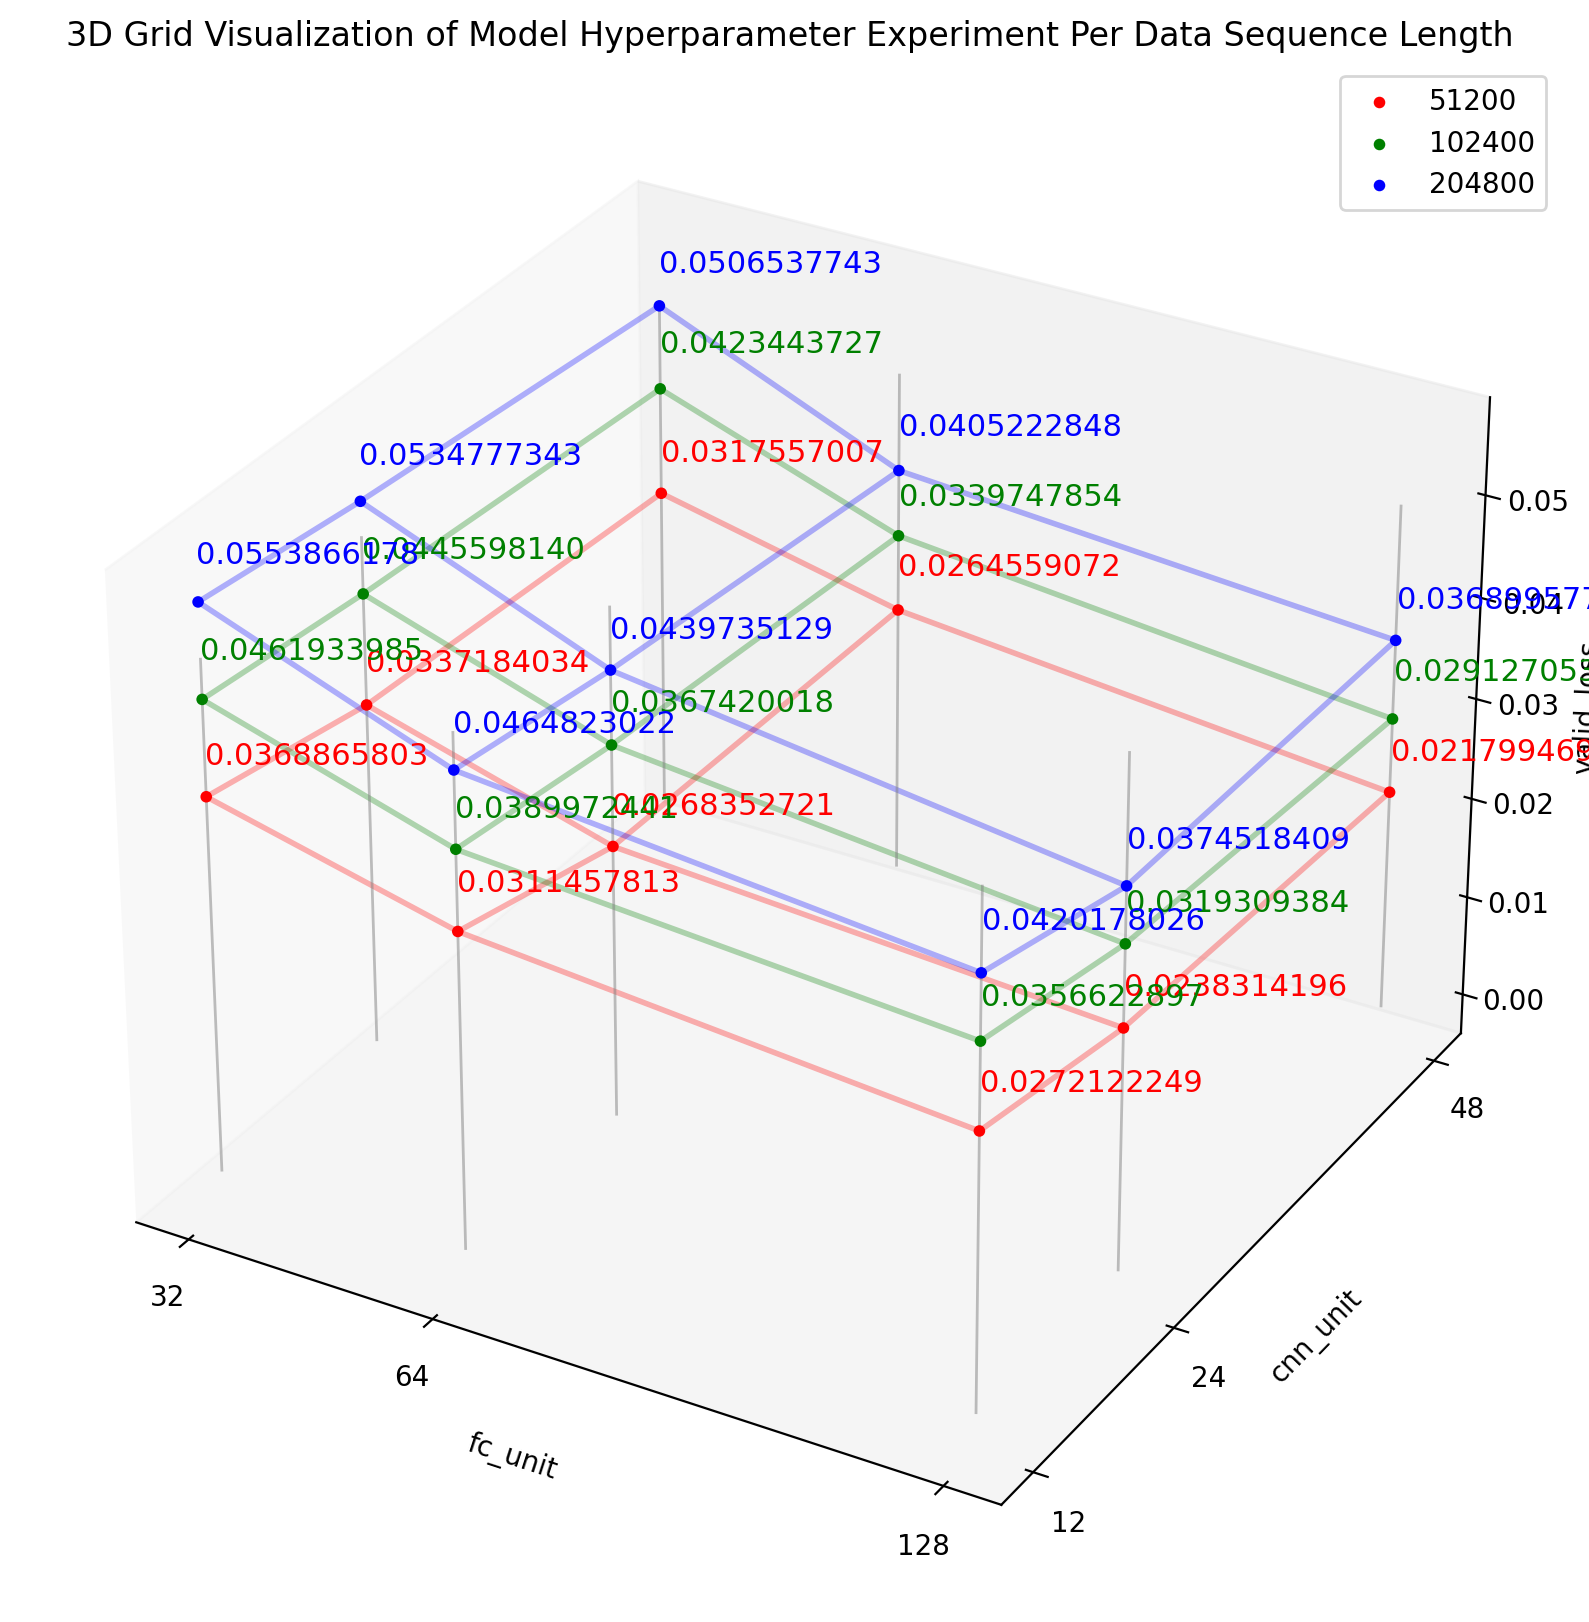

In [29]:
import matplotlib.pyplot as plt
# 색상 매핑
colors = dict(zip(sequence_lengths,['r','g','b']))
# 3D 그래프 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# 파라미터
line_alpha = 0.3
line_width = 2
dot_size = 10
dot_alpha = 1

# List to keep track of the used label positions
used_positions = {}
offset = 5
z_scale = 1e-3
for sequence_length in sequence_lengths:
    subset = best_df[best_df['sequence_length'] == sequence_length].sort_values(by=['fc_unit', 'cnn_unit'])
    ax.scatter(subset['fc_unit'], subset['cnn_unit'], subset['valid_loss'],
               c=colors[sequence_length], label=sequence_length, s=dot_size, alpha=dot_alpha)

    # 세로줄
    for cnn_unit in cnn_units:
        sub = subset[subset['cnn_unit'] == cnn_unit].sort_values(by='fc_unit')
        ax.plot(sub['fc_unit'], sub['cnn_unit'], sub['valid_loss'], c=colors[sequence_length], alpha=line_alpha, linewidth=line_width)
    # 가로줄
    for fc_unit in fc_units:
        sub = subset[subset['fc_unit'] == fc_unit].sort_values(by='cnn_unit')
        ax.plot(sub['fc_unit'], sub['cnn_unit'], sub['valid_loss'], c=colors[sequence_length], alpha=line_alpha, linewidth=line_width)

    # 텍스트
    for i in range(len(subset)):
        valid_loss = subset['valid_loss'].iloc[i]
        x_pos = subset['fc_unit'].iloc[i]
        y_pos = subset['cnn_unit'].iloc[i]
        z_pos = np.floor(valid_loss / z_scale) + 4  # Default z offset for text
        # Check if the position is already used and adjust accordingly
        while (x_pos, y_pos, z_pos) in used_positions:
            if valid_loss < used_positions[(x_pos, y_pos, z_pos)]:
                z_pos -= offset  # Decrease the z offset if the position is already taken
            else:
                z_pos += offset  # Increase the z offset if the position is already taken
        # Add the position to the used positions dictionary
        for i in range(offset):
            used_positions[(x_pos, y_pos, z_pos-i)] = valid_loss
            used_positions[(x_pos, y_pos, z_pos+i)] = valid_loss
        ax.text(x_pos, y_pos, z_pos * z_scale, f"{valid_loss:.10f}", color=colors[sequence_length], fontsize=11)

# Each (x, y) intersection: Draw vertical lines in the z direction
for fc_unit in fc_units:
    for cnn_unit in cnn_units:
        ax.plot([fc_unit, fc_unit], [cnn_unit, cnn_unit], [0, 0.05], c='gray', alpha=.5, linewidth=1)

# Set custom ticks
ax.set_xticks(fc_units)
ax.set_yticks(cnn_units)
ax.set_xlabel('fc_unit')
ax.set_ylabel('cnn_unit')
ax.set_zlabel('valid_loss')
ax.set_title('3D Grid Visualization of Model Hyperparameter Experiment Per Data Sequence Length')
ax.grid(False)
ax.legend()
plt.show()

### Experiment2 : Training Hyperparameters

In [ ]:
batch_size = 16
iterations=3000
validation_interval=1000

sequence_length=51200
cnn_unit=48
fc_unit=128

learning_rates=[1e-4,1e-3,1e-2]
weight_decays=[0.0,1e-4,1e-3]

NUM_EPOCHS = 10

valid_losses2 = []
results2 = []

train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
  
for learning_rate in learning_rates:
  for weight_decay in weight_decays:          
    print(f"Training with learning_rate={learning_rate}, weight_decay={weight_decay}")
    
    model = BasicOnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit)
    runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

    for epoch in range(NUM_EPOCHS):
      print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
      train_loss = runner.train(train_loader)
      valid_loss, result = runner.test(valid_loader)
      valid_losses2.append(valid_loss)
      results2.append(result)
    print()
    
import pickle
with open('valid_losses2.pkl', 'wb') as f:
    pickle.dump(valid_losses2, f)
with open('results2.pkl', 'wb') as f:
    pickle.dump(results2, f)

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


Training with learning_rate=0.0001, weight_decay=0.0
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.40it/s, loss: 1.685e-01]
/home/airis_lab/JL/GCT634/.venv/lib/python3.10/site-packages/mir_eval/transcription.py:163: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


metric/frame/frame_f1       : 0.6353
metric/frame/onset_f1       : 0.3526
metric/note/f1              : 0.3910
metric/note-with-offsets/f1 : 0.1435
[Epoch 2/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.70it/s, loss: 1.837e-01]


metric/frame/frame_f1       : 0.7105
metric/frame/onset_f1       : 0.6052
metric/note/f1              : 0.6679
metric/note-with-offsets/f1 : 0.3496
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.76it/s, loss: 1.540e-01]


metric/frame/frame_f1       : 0.7210
metric/frame/onset_f1       : 0.6502
metric/note/f1              : 0.7211
metric/note-with-offsets/f1 : 0.4029
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s, loss: 2.338e-01]


metric/frame/frame_f1       : 0.7198
metric/frame/onset_f1       : 0.6423
metric/note/f1              : 0.7227
metric/note-with-offsets/f1 : 0.3751
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 8.800e-02]


metric/frame/frame_f1       : 0.7284
metric/frame/onset_f1       : 0.6824
metric/note/f1              : 0.7837
metric/note-with-offsets/f1 : 0.4022
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.78it/s, loss: 9.619e-02]


metric/frame/frame_f1       : 0.7303
metric/frame/onset_f1       : 0.6716
metric/note/f1              : 0.7650
metric/note-with-offsets/f1 : 0.3605
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.87it/s, loss: 1.153e-01]


metric/frame/frame_f1       : 0.7461
metric/frame/onset_f1       : 0.6917
metric/note/f1              : 0.8111
metric/note-with-offsets/f1 : 0.3803
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.91it/s, loss: 1.133e-01]


metric/frame/frame_f1       : 0.7640
metric/frame/onset_f1       : 0.6756
metric/note/f1              : 0.7695
metric/note-with-offsets/f1 : 0.4360
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.74it/s, loss: 1.308e-01]


metric/frame/frame_f1       : 0.7633
metric/frame/onset_f1       : 0.6874
metric/note/f1              : 0.7997
metric/note-with-offsets/f1 : 0.4087
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.81it/s, loss: 1.252e-01]


metric/frame/frame_f1       : 0.7560
metric/frame/onset_f1       : 0.6942
metric/note/f1              : 0.7869
metric/note-with-offsets/f1 : 0.4897

Training with learning_rate=0.0001, weight_decay=0.0001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.01it/s, loss: 1.899e-01]


metric/frame/frame_f1       : 0.6166
metric/frame/onset_f1       : 0.3879
metric/note/f1              : 0.4260
metric/note-with-offsets/f1 : 0.2227
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s, loss: 1.389e-01]


metric/frame/frame_f1       : 0.6722
metric/frame/onset_f1       : 0.5699
metric/note/f1              : 0.6306
metric/note-with-offsets/f1 : 0.3825
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.67it/s, loss: 1.636e-01]


metric/frame/frame_f1       : 0.7097
metric/frame/onset_f1       : 0.5775
metric/note/f1              : 0.6458
metric/note-with-offsets/f1 : 0.3716
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s, loss: 1.307e-01]


metric/frame/frame_f1       : 0.7221
metric/frame/onset_f1       : 0.6077
metric/note/f1              : 0.6872
metric/note-with-offsets/f1 : 0.4058
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s, loss: 1.258e-01]


metric/frame/frame_f1       : 0.7122
metric/frame/onset_f1       : 0.6508
metric/note/f1              : 0.7210
metric/note-with-offsets/f1 : 0.4050
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s, loss: 1.372e-01]


metric/frame/frame_f1       : 0.7231
metric/frame/onset_f1       : 0.6427
metric/note/f1              : 0.7277
metric/note-with-offsets/f1 : 0.4343
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.78it/s, loss: 9.807e-02]


metric/frame/frame_f1       : 0.7590
metric/frame/onset_f1       : 0.6571
metric/note/f1              : 0.7420
metric/note-with-offsets/f1 : 0.4093
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.80it/s, loss: 1.457e-01]


metric/frame/frame_f1       : 0.7644
metric/frame/onset_f1       : 0.6093
metric/note/f1              : 0.6915
metric/note-with-offsets/f1 : 0.4139
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 1.194e-01]


metric/frame/frame_f1       : 0.7488
metric/frame/onset_f1       : 0.6313
metric/note/f1              : 0.7115
metric/note-with-offsets/f1 : 0.4444
[Epoch 10/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.55it/s, loss: 1.731e-01]


metric/frame/frame_f1       : 0.7534
metric/frame/onset_f1       : 0.6209
metric/note/f1              : 0.7094
metric/note-with-offsets/f1 : 0.4091

Training with learning_rate=0.0001, weight_decay=0.001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.60it/s, loss: 2.428e-01]


metric/frame/frame_f1       : 0.5730
metric/frame/onset_f1       : 0.2068
metric/note/f1              : 0.2135
metric/note-with-offsets/f1 : 0.0720
[Epoch 2/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.42it/s, loss: 1.606e-01]


metric/frame/frame_f1       : 0.5996
metric/frame/onset_f1       : 0.3319
metric/note/f1              : 0.3601
metric/note-with-offsets/f1 : 0.1836
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 1.798e-01]


metric/frame/frame_f1       : 0.6429
metric/frame/onset_f1       : 0.3124
metric/note/f1              : 0.3304
metric/note-with-offsets/f1 : 0.1744
[Epoch 4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.55it/s, loss: 1.638e-01]


metric/frame/frame_f1       : 0.5562
metric/frame/onset_f1       : 0.2686
metric/note/f1              : 0.2759
metric/note-with-offsets/f1 : 0.1349
[Epoch 5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.64it/s, loss: 1.436e-01]


metric/frame/frame_f1       : 0.6724
metric/frame/onset_f1       : 0.2110
metric/note/f1              : 0.2198
metric/note-with-offsets/f1 : 0.1584
[Epoch 6/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.66it/s, loss: 1.546e-01]


metric/frame/frame_f1       : 0.6561
metric/frame/onset_f1       : 0.2055
metric/note/f1              : 0.2176
metric/note-with-offsets/f1 : 0.1414
[Epoch 7/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.70it/s, loss: 1.011e-01]


metric/frame/frame_f1       : 0.6730
metric/frame/onset_f1       : 0.1931
metric/note/f1              : 0.1957
metric/note-with-offsets/f1 : 0.1507
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.89it/s, loss: 1.367e-01]


metric/frame/frame_f1       : 0.6749
metric/frame/onset_f1       : 0.1694
metric/note/f1              : 0.1697
metric/note-with-offsets/f1 : 0.1199
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.89it/s, loss: 1.594e-01]


metric/frame/frame_f1       : 0.6783
metric/frame/onset_f1       : 0.1086
metric/note/f1              : 0.1114
metric/note-with-offsets/f1 : 0.0777
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s, loss: 1.529e-01]


metric/frame/frame_f1       : 0.6403
metric/frame/onset_f1       : 0.1086
metric/note/f1              : 0.1086
metric/note-with-offsets/f1 : 0.0695

Training with learning_rate=0.001, weight_decay=0.0
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.72it/s, loss: 1.471e-01]


metric/frame/frame_f1       : 0.6073
metric/frame/onset_f1       : 0.5768
metric/note/f1              : 0.6506
metric/note-with-offsets/f1 : 0.3282
[Epoch 2/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.069e-01]


metric/frame/frame_f1       : 0.6764
metric/frame/onset_f1       : 0.6206
metric/note/f1              : 0.7010
metric/note-with-offsets/f1 : 0.4188
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.70it/s, loss: 1.378e-01]


metric/frame/frame_f1       : 0.7338
metric/frame/onset_f1       : 0.6832
metric/note/f1              : 0.7891
metric/note-with-offsets/f1 : 0.4305
[Epoch 4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.52it/s, loss: 1.135e-01]


metric/frame/frame_f1       : 0.6943
metric/frame/onset_f1       : 0.6989
metric/note/f1              : 0.7861
metric/note-with-offsets/f1 : 0.3966
[Epoch 5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s, loss: 1.281e-01]


metric/frame/frame_f1       : 0.7487
metric/frame/onset_f1       : 0.7180
metric/note/f1              : 0.7957
metric/note-with-offsets/f1 : 0.4962
[Epoch 6/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s, loss: 1.457e-01]


metric/frame/frame_f1       : 0.7607
metric/frame/onset_f1       : 0.6812
metric/note/f1              : 0.7625
metric/note-with-offsets/f1 : 0.5098
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s, loss: 1.527e-01]


metric/frame/frame_f1       : 0.7425
metric/frame/onset_f1       : 0.7189
metric/note/f1              : 0.7971
metric/note-with-offsets/f1 : 0.5283
[Epoch 8/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.70it/s, loss: 1.066e-01]


metric/frame/frame_f1       : 0.7415
metric/frame/onset_f1       : 0.7215
metric/note/f1              : 0.8035
metric/note-with-offsets/f1 : 0.5296
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.025e-01]


metric/frame/frame_f1       : 0.7345
metric/frame/onset_f1       : 0.7016
metric/note/f1              : 0.8012
metric/note-with-offsets/f1 : 0.4842
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.83it/s, loss: 1.454e-01]


metric/frame/frame_f1       : 0.7657
metric/frame/onset_f1       : 0.7182
metric/note/f1              : 0.8052
metric/note-with-offsets/f1 : 0.4723

Training with learning_rate=0.001, weight_decay=0.0001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s, loss: 2.102e-01]


metric/frame/frame_f1       : 0.1603
metric/frame/onset_f1       : 0.5780
metric/note/f1              : 0.6250
metric/note-with-offsets/f1 : 0.0529
[Epoch 2/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 1.654e-01]


metric/frame/frame_f1       : 0.6306
metric/frame/onset_f1       : 0.4693
metric/note/f1              : 0.4930
metric/note-with-offsets/f1 : 0.2813
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.61it/s, loss: 1.166e-01]


metric/frame/frame_f1       : 0.6605
metric/frame/onset_f1       : 0.5861
metric/note/f1              : 0.6251
metric/note-with-offsets/f1 : 0.3473
[Epoch 4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.69it/s, loss: 1.791e-01]


metric/frame/frame_f1       : 0.7161
metric/frame/onset_f1       : 0.5456
metric/note/f1              : 0.5932
metric/note-with-offsets/f1 : 0.3667
[Epoch 5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.43it/s, loss: 1.433e-01]


metric/frame/frame_f1       : 0.7352
metric/frame/onset_f1       : 0.6178
metric/note/f1              : 0.6828
metric/note-with-offsets/f1 : 0.3968
[Epoch 6/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 1.836e-01]


metric/frame/frame_f1       : 0.7203
metric/frame/onset_f1       : 0.5895
metric/note/f1              : 0.6497
metric/note-with-offsets/f1 : 0.3597
[Epoch 7/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.68it/s, loss: 1.622e-01]


metric/frame/frame_f1       : 0.7512
metric/frame/onset_f1       : 0.5592
metric/note/f1              : 0.5942
metric/note-with-offsets/f1 : 0.4017
[Epoch 8/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.61it/s, loss: 1.223e-01]


metric/frame/frame_f1       : 0.6858
metric/frame/onset_f1       : 0.6496
metric/note/f1              : 0.7257
metric/note-with-offsets/f1 : 0.3605
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.56it/s, loss: 1.721e-01]


metric/frame/frame_f1       : 0.7586
metric/frame/onset_f1       : 0.6263
metric/note/f1              : 0.6872
metric/note-with-offsets/f1 : 0.4616
[Epoch 10/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.72it/s, loss: 1.062e-01]


metric/frame/frame_f1       : 0.7169
metric/frame/onset_f1       : 0.6001
metric/note/f1              : 0.6337
metric/note-with-offsets/f1 : 0.4565

Training with learning_rate=0.001, weight_decay=0.001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.75it/s, loss: 1.589e-01]


metric/frame/frame_f1       : 0.3988
metric/frame/onset_f1       : 0.1739
metric/note/f1              : 0.1770
metric/note-with-offsets/f1 : 0.0345
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s, loss: 1.751e-01]


metric/frame/frame_f1       : 0.4861
metric/frame/onset_f1       : 0.0286
metric/note/f1              : 0.0286
metric/note-with-offsets/f1 : 0.0045
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s, loss: 1.580e-01]


metric/frame/frame_f1       : 0.5033
metric/frame/onset_f1       : 0.0031
metric/note/f1              : 0.0031
metric/note-with-offsets/f1 : 0.0000
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.04it/s, loss: 2.153e-01]


metric/frame/frame_f1       : 0.5954
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s, loss: 2.026e-01]


metric/frame/frame_f1       : 0.4991
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s, loss: 2.136e-01]


metric/frame/frame_f1       : 0.0726
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s, loss: 1.886e-01]


metric/frame/frame_f1       : 0.5652
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 2.173e-01]


metric/frame/frame_f1       : 0.5834
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.05it/s, loss: 1.604e-01]


metric/frame/frame_f1       : 0.5082
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 1.617e-01]


metric/frame/frame_f1       : 0.6264
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

Training with learning_rate=0.01, weight_decay=0.0
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s, loss: 5.481e-01]


metric/frame/frame_f1       : 0.1135
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.31it/s, loss: 4.818e-01]


metric/frame/frame_f1       : 0.3152
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s, loss: 5.737e-01]


metric/frame/frame_f1       : 0.4938
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 5.573e-01]


metric/frame/frame_f1       : 0.5363
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s, loss: 5.341e-01]


metric/frame/frame_f1       : 0.5570
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.23it/s, loss: 4.506e-01]


metric/frame/frame_f1       : 0.5409
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s, loss: 6.566e-01]


metric/frame/frame_f1       : 0.5333
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s, loss: 4.667e-01]


metric/frame/frame_f1       : 0.5329
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.22it/s, loss: 4.734e-01]


metric/frame/frame_f1       : 0.5718
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.16it/s, loss: 6.119e-01]


metric/frame/frame_f1       : 0.5695
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

Training with learning_rate=0.01, weight_decay=0.0001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.79it/s, loss: 2.182e-01]


metric/frame/frame_f1       : 0.1219
metric/frame/onset_f1       : 0.4023
metric/note/f1              : 0.4527
metric/note-with-offsets/f1 : 0.0399
[Epoch 2/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s, loss: 2.155e-01]


metric/frame/frame_f1       : 0.4032
metric/frame/onset_f1       : 0.2967
metric/note/f1              : 0.3247
metric/note-with-offsets/f1 : 0.1438
[Epoch 3/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.60it/s, loss: 2.146e-01]


metric/frame/frame_f1       : 0.3114
metric/frame/onset_f1       : 0.2140
metric/note/f1              : 0.2229
metric/note-with-offsets/f1 : 0.0413
[Epoch 4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.66it/s, loss: 1.497e-01]


metric/frame/frame_f1       : 0.4317
metric/frame/onset_f1       : 0.3215
metric/note/f1              : 0.3615
metric/note-with-offsets/f1 : 0.1555
[Epoch 5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.68it/s, loss: 1.708e-01]


metric/frame/frame_f1       : 0.5425
metric/frame/onset_f1       : 0.2704
metric/note/f1              : 0.2930
metric/note-with-offsets/f1 : 0.1277
[Epoch 6/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.74it/s, loss: 1.507e-01]


metric/frame/frame_f1       : 0.4976
metric/frame/onset_f1       : 0.4346
metric/note/f1              : 0.4629
metric/note-with-offsets/f1 : 0.1780
[Epoch 7/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.61it/s, loss: 1.940e-01]


metric/frame/frame_f1       : 0.5526
metric/frame/onset_f1       : 0.3673
metric/note/f1              : 0.3940
metric/note-with-offsets/f1 : 0.1699
[Epoch 8/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 2.384e-01]


metric/frame/frame_f1       : 0.4992
metric/frame/onset_f1       : 0.3076
metric/note/f1              : 0.3220
metric/note-with-offsets/f1 : 0.1211
[Epoch 9/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.63it/s, loss: 1.919e-01]


metric/frame/frame_f1       : 0.5301
metric/frame/onset_f1       : 0.4636
metric/note/f1              : 0.5017
metric/note-with-offsets/f1 : 0.2300
[Epoch 10/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s, loss: 1.829e-01]


metric/frame/frame_f1       : 0.3676
metric/frame/onset_f1       : 0.2806
metric/note/f1              : 0.3357
metric/note-with-offsets/f1 : 0.0878

Training with learning_rate=0.01, weight_decay=0.001
[Epoch 1/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.69it/s, loss: 1.834e-01]


metric/frame/frame_f1       : 0.1694
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 2.199e-01]


metric/frame/frame_f1       : 0.3502
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 3/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s, loss: 2.349e-01]


metric/frame/frame_f1       : 0.0757
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 4/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s, loss: 2.387e-01]


metric/frame/frame_f1       : 0.1163
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 5/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.00it/s, loss: 1.691e-01]


metric/frame/frame_f1       : 0.1915
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.02it/s, loss: 2.244e-01]


metric/frame/frame_f1       : 0.0786
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s, loss: 2.332e-01]


metric/frame/frame_f1       : 0.2574
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.06it/s, loss: 2.534e-01]


metric/frame/frame_f1       : 0.2890
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 9/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s, loss: 2.555e-01]


metric/frame/frame_f1       : 0.2967
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 10/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s, loss: 2.102e-01]


metric/frame/frame_f1       : 0.3329
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000



In [ ]:
import pickle
with open('valid_losses2.pkl', 'rb') as f:
  valid_losses = pickle.load(f)
with open('results2.pkl', 'rb') as f:
  results = pickle.load(f)
  
import pandas as pd
from itertools import product

learning_rates=[1e-4,1e-3,1e-2]
weight_decays=[0.0,1e-4,1e-3]
NUM_EPOCHS = 10

df = pd.DataFrame(product(learning_rates, weight_decays, range(1,NUM_EPOCHS+1)), columns=['learning_rate', 'weight_decay', 'epoch'])
df['valid_loss'] = valid_losses
df = pd.concat([df, pd.DataFrame(results)],axis=1)
df

learning_rate  weight_decay  epoch  valid_loss metric/loss/frame_loss  \
0          0.0001         0.000      1    0.038834           [0.07628303]   
1          0.0001         0.000      2    0.033171            [0.0658342]   
2          0.0001         0.000      3    0.028877          [0.058661126]   
3          0.0001         0.000      4    0.027784          [0.056985334]   
4          0.0001         0.000      5    0.029314          [0.058624644]   
..            ...           ...    ...         ...                    ...   
85         0.0100         0.001      6    0.055824           [0.10583144]   
86         0.0100         0.001      7    0.062509           [0.12132373]   
87         0.0100         0.001      8    0.068381           [0.13632071]   
88         0.0100         0.001      9    0.075050           [0.13436401]   
89         0.0100         0.001     10    0.076650           [0.14185509]   

   metric/loss/onset_loss                       metric/frame/frame_precision  \
0          [0.0065105585]  [0.7959183673469388, 0.9176470588235294, 0.875...   
1           [0.004689644]  [0.7641509433962265, 0.8422391857506362, 0.900...   
2          [0.0035164452]  [0.7727272727272727, 0.9702380952380952, 0.9, ...   
3           [0.003041231]  [0.8278145695364238, 0.9726027397260274, 0.929...   
4          [0.0030161126]  [0.8177777777777778, 0.9558011049723757, 0.900...   
..                    ...                                                ...   
85          [0.014694749]  [0, 0.9065934065934066, 0.9545454545454546, 0....   
86            [0.0123865]  [0.13333333333333333, 0.9863013698630136, 0.47...   
87          [0.013352099]  [0.6379310344827587, 0.4944356120826709, 0.610...   
88           [0.02134616]  [0.0, 0.6530612244897959, 0.77, 0.678899082568...   
89          [0.017409418]  [0.06666666666666667, 0.788, 0.830645161290322...   

                            metric/frame/frame_recall  \
0   [0.2314540059347181, 0.7027027027027027, 0.629...   
1   [0.4807121661721068, 0.7454954954954955, 0.629...   
2   [0.4035608308605341, 0.7342342342342343, 0.625...   
3   [0.37091988130563797, 0.6396396396396397, 0.61...   
4   [0.5459940652818991, 0.7792792792792793, 0.692...   
..                                                ...   
85  [0.0, 0.3716216216216216, 0.0695364238410596, ...   
86  [0.017804154302670624, 0.32432432432432434, 0....   
87  [0.10979228486646884, 0.7004504504504504, 0.27...   
88  [0.0, 0.21621621621621623, 0.25496688741721857...   
89  [0.002967359050445104, 0.4436936936936937, 0.3...   

                                metric/frame/frame_f1  \
0   [0.3586206896551724, 0.7959183673469388, 0.732...   
1   [0.5901639344262295, 0.7909199522102748, 0.740...   
2   [0.5302144249512671, 0.835897435897436, 0.7382...   
3   [0.5122950819672131, 0.7717391304347826, 0.738...   
4   [0.6548042704626335, 0.8585607940446651, 0.782...   
..                                                ...   
85  [0, 0.5271565495207668, 0.12962962962962962, 0...   
86  [0.031413612565445025, 0.488135593220339, 0.30...   
87  [0.18734177215189873, 0.5796831314072693, 0.37...   
88  [0, 0.3248730964467005, 0.3830845771144279, 0....   
89  [0.005681818181818181, 0.5677233429394812, 0.4...   

                         metric/frame/onset_precision  \
0   [0.5, 0.6666666666666666, 0.7272727272727273, ...   
1   [0.6923076923076923, 0.75, 0.8095238095238095,...   
2   [0.6666666666666666, 0.7777777777777778, 0.894...   
3               [0.7, 0.875, 0.9, 0.9230769230769231]   
4   [0.6428571428571429, 0.8333333333333334, 0.9, ...   
..                                                ...   
85                                       [0, 0, 0, 0]   
86                                       [0, 0, 0, 0]   
87                                       [0, 0, 0, 0]   
88                                       [0, 0, 0, 0]   
89                                       [0, 0, 0, 0]   

                            metric/frame/onset_recall  \
0   [0

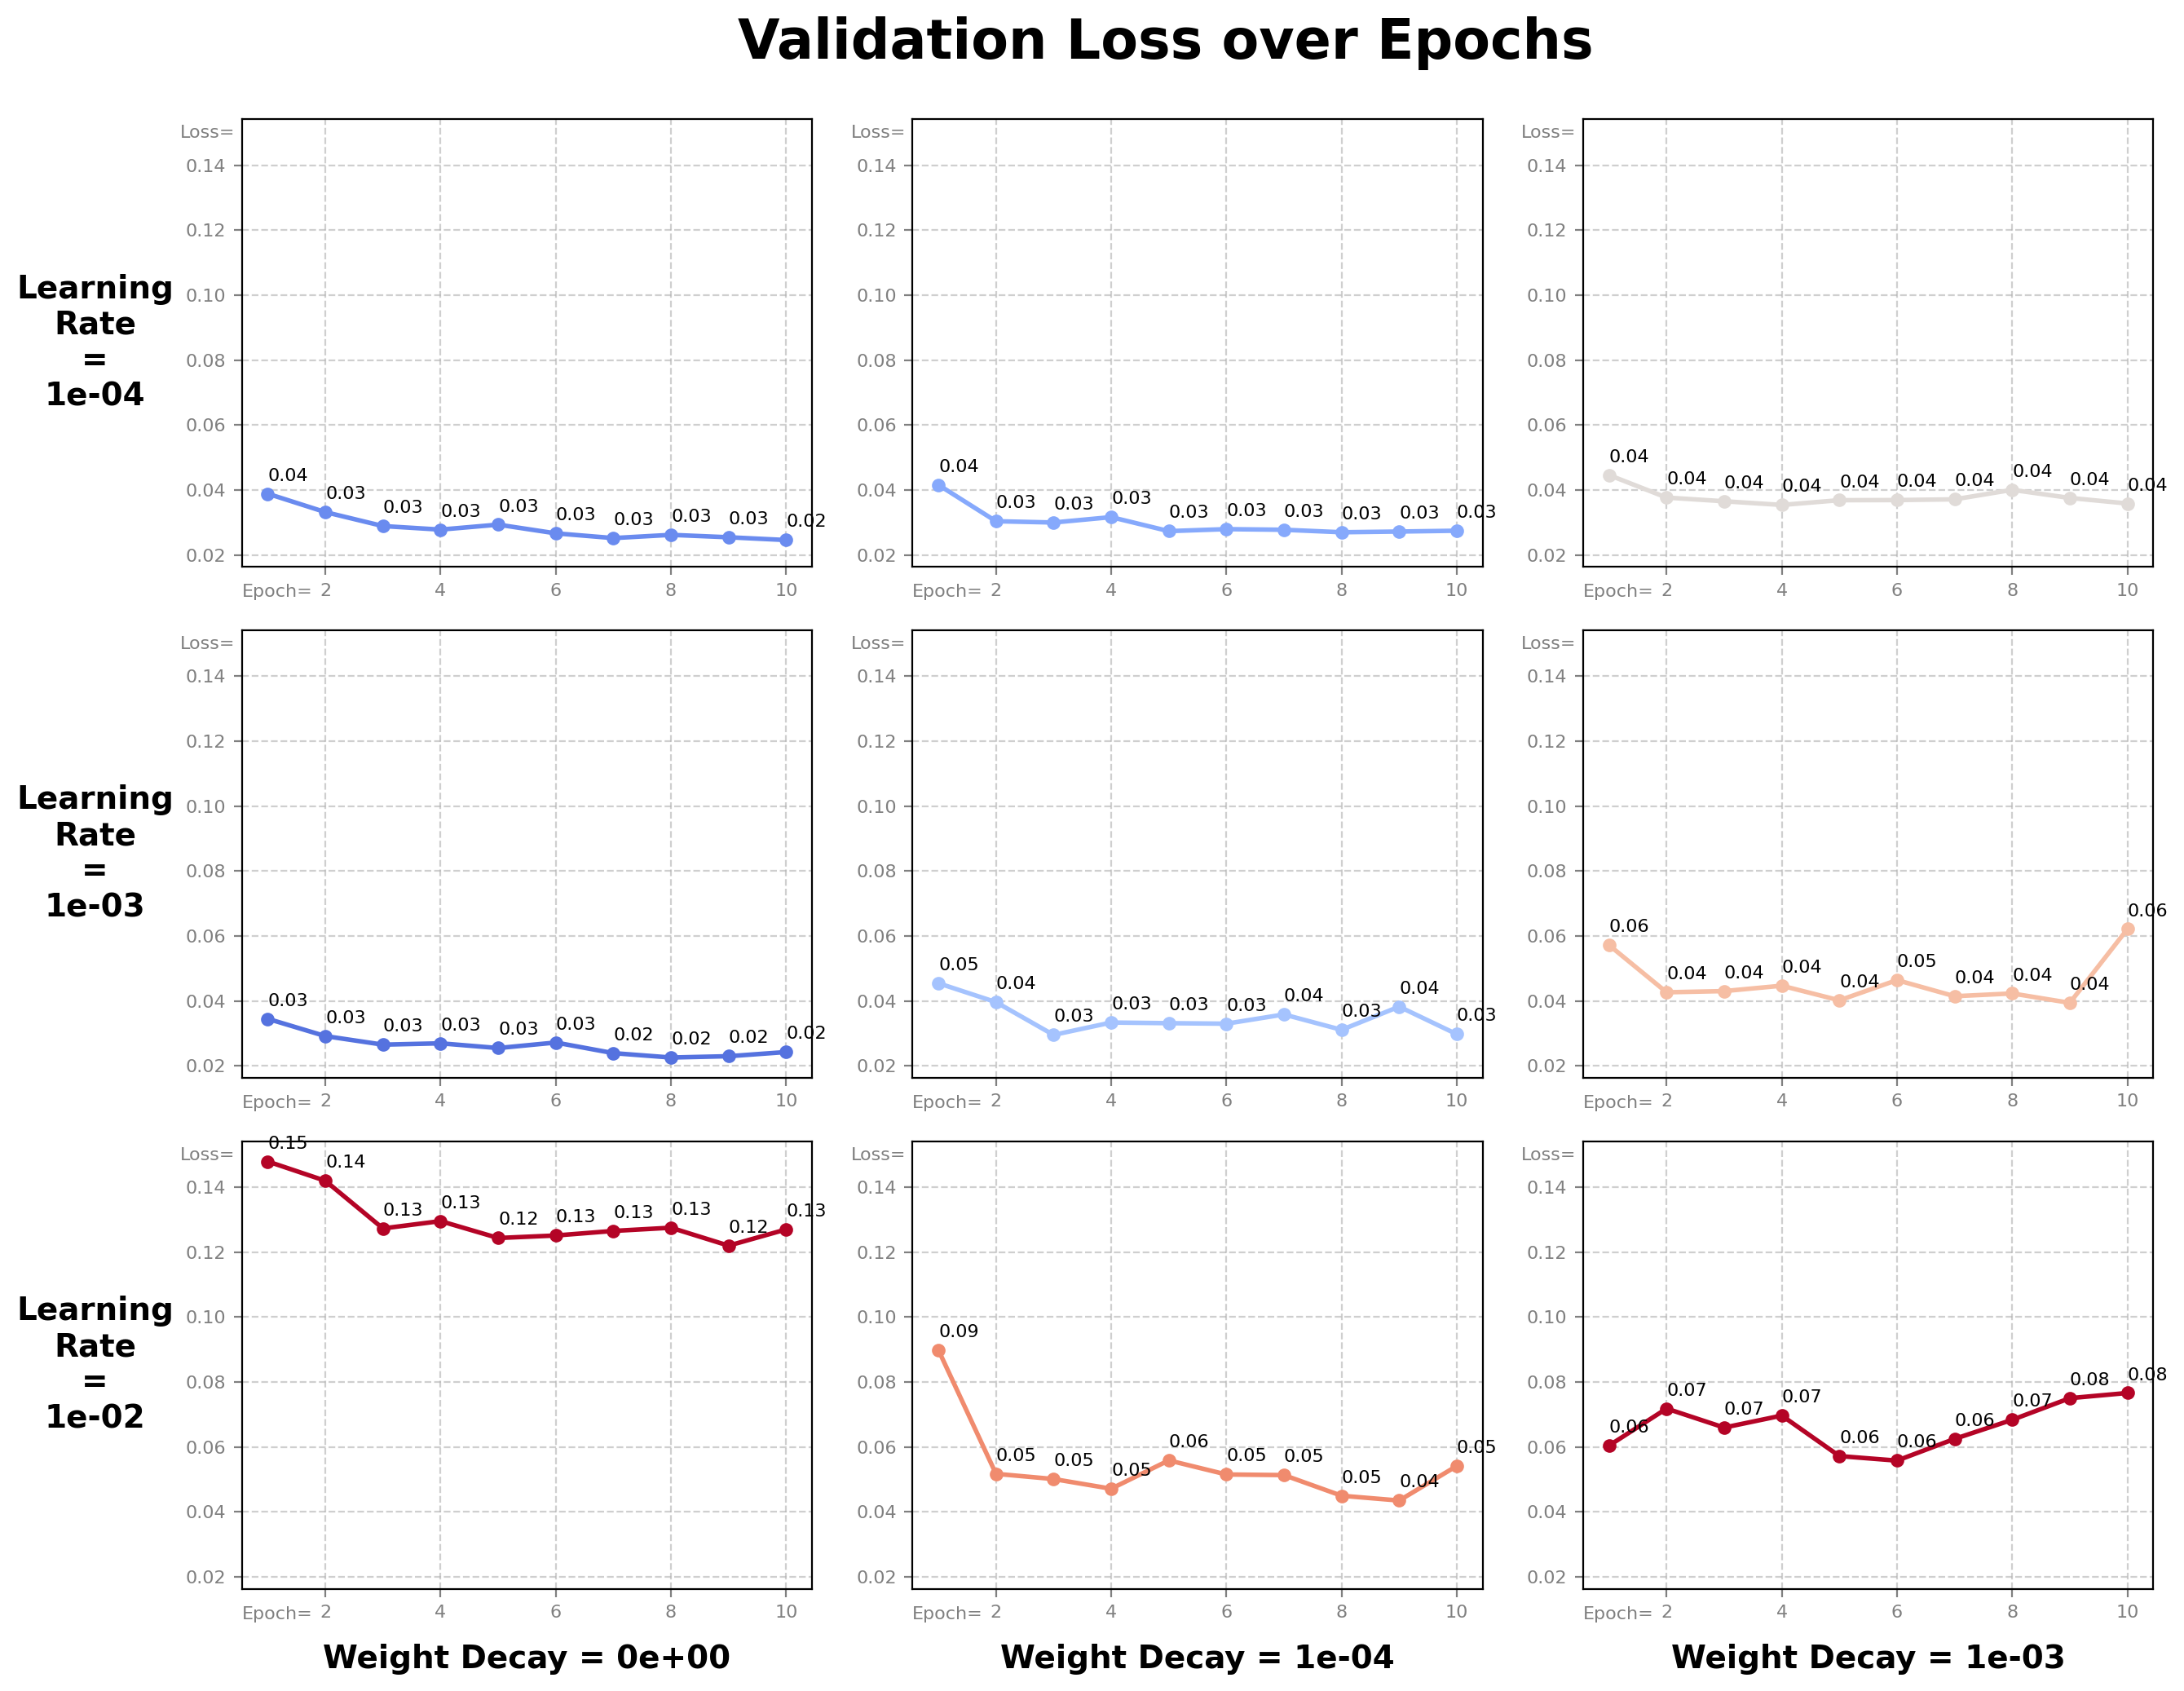

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# 색상 맵 설정 (최솟값에 비례하는 색상)
cmap = plt.get_cmap('coolwarm')

for i, lr in enumerate(learning_rates):
    for j, wd in enumerate(weight_decays):
        ax = axes[i, j]
        subset = df[(df['learning_rate'] == lr) & (df['weight_decay'] == wd)]
        subset = subset.sort_values('epoch')
        
        # 각 서브그래프의 최솟값 찾기
        min_loss = subset['valid_loss'].min()
        
        # 최솟값에 비례하는 색상 계산
        norm = plt.Normalize(vmin=0.02, vmax=0.05, clip=True)
        color = cmap(norm(min_loss))

        # 그래프 그리기
        ax.plot(subset['epoch'], subset['valid_loss'], marker='o', linewidth=2, markersize=5, color=color)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # 모든 subplot에 눈금 켜기
        ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True, labelsize=8, colors='gray')
        
        # 왼쪽 (y축) 옆에 learning rate
        if j == 0:
            ax.set_ylabel(f"Learning\nRate\n=\n{lr:.0e}", fontsize=14, weight='bold', rotation=0, labelpad=40, va='center')
        
        # x축 아래에 weight decay 표시
        if i == 2:  # 맨 아래 플롯들
            ax.set_xlabel(f"Weight Decay = {wd:.0e}", fontsize=14, weight='bold', labelpad=10)

        # 각 플롯마다 추가 텍스트: (x축 왼쪽에 Epoch, y축 위에 Validation Loss)
        ax.annotate("Epoch=", xy=(-0.0, -0.056), xycoords='axes fraction',
                    ha='left', va='center', fontsize=8, color='gray')
        ax.annotate("Loss=", xy=(-0.06, 0.95), xycoords='axes fraction',
                    ha='center', va='bottom', fontsize=8, color='gray')
        
        # 각 포인트마다 값 표시
        for xi, yi in zip(subset['epoch'], subset['valid_loss']):
            ax.text(xi, yi+0.003, f"{yi:.2f}", fontsize=8, color='black', ha='left', va='bottom')

# 전체 큰 제목
fig.suptitle("Validation Loss over Epochs", fontsize=24, weight='bold', x=0.58, y=0.93)

plt.tight_layout(rect=[0.1, 0.07, 1, 0.93])
plt.show()

### Experiment3 : RNN unit Comparison on Second Model

In [87]:
batch_size = 16
iterations=3000
validation_interval=1000

sequence_length=51200
cnn_unit=48
fc_unit=128
rnn_units=[32, 64, 128]

learning_rate = 1e-3
weight_decay = 0.0

NUM_EPOCHS = 20

valid_losses3 = []
results3 = []

train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

for rnn_unit in rnn_units:
  print(f"Training with rnn_unit={rnn_unit}")

  model = OnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit, rnn_unit=rnn_unit)
  runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

  for epoch in range(NUM_EPOCHS):
    print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
    train_loss = runner.train(train_loader)
    valid_loss, result = runner.test(valid_loader)
    valid_losses3.append(valid_loss)
    results3.append(result)
  print()

import pickle
with open('valid_losses3.pkl', 'wb') as f:
    pickle.dump(valid_losses3, f)
with open('results3.pkl', 'wb') as f:
    pickle.dump(results3, f)

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


Training with rnn_unit=32
[Epoch 1/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s, loss: 2.163e-01]
/home/airis_lab/JL/GCT634/.venv/lib/python3.10/site-packages/mir_eval/transcription.py:163: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s, loss: 2.299e-01]


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 3/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s, loss: 2.429e-01]


metric/frame/frame_f1       : 0.0013
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 4/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.48it/s, loss: 1.459e-01]


metric/frame/frame_f1       : 0.0408
metric/frame/onset_f1       : 0.3491
metric/note/f1              : 0.3795
metric/note-with-offsets/f1 : 0.0464
[Epoch 5/20]


100%|██████████| 1000/1000 [00:38<00:00, 26.30it/s, loss: 1.699e-01]


metric/frame/frame_f1       : 0.3366
metric/frame/onset_f1       : 0.5686
metric/note/f1              : 0.6256
metric/note-with-offsets/f1 : 0.1672
[Epoch 6/20]


100%|██████████| 1000/1000 [00:38<00:00, 26.08it/s, loss: 1.376e-01]


metric/frame/frame_f1       : 0.4137
metric/frame/onset_f1       : 0.6178
metric/note/f1              : 0.7106
metric/note-with-offsets/f1 : 0.2291
[Epoch 7/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.36it/s, loss: 1.849e-01]


metric/frame/frame_f1       : 0.4876
metric/frame/onset_f1       : 0.6872
metric/note/f1              : 0.7641
metric/note-with-offsets/f1 : 0.2092
[Epoch 8/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.46it/s, loss: 1.097e-01]


metric/frame/frame_f1       : 0.5186
metric/frame/onset_f1       : 0.6922
metric/note/f1              : 0.7735
metric/note-with-offsets/f1 : 0.2556
[Epoch 9/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.43it/s, loss: 1.397e-01]


metric/frame/frame_f1       : 0.4744
metric/frame/onset_f1       : 0.7258
metric/note/f1              : 0.7995
metric/note-with-offsets/f1 : 0.3215
[Epoch 10/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.46it/s, loss: 1.169e-01]


metric/frame/frame_f1       : 0.5659
metric/frame/onset_f1       : 0.7005
metric/note/f1              : 0.7895
metric/note-with-offsets/f1 : 0.3450
[Epoch 11/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.54it/s, loss: 9.252e-02]


metric/frame/frame_f1       : 0.6020
metric/frame/onset_f1       : 0.7119
metric/note/f1              : 0.7989
metric/note-with-offsets/f1 : 0.3092
[Epoch 12/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s, loss: 8.988e-02]


metric/frame/frame_f1       : 0.6230
metric/frame/onset_f1       : 0.7064
metric/note/f1              : 0.7900
metric/note-with-offsets/f1 : 0.3622
[Epoch 13/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.48it/s, loss: 1.497e-01]


metric/frame/frame_f1       : 0.6468
metric/frame/onset_f1       : 0.7265
metric/note/f1              : 0.8254
metric/note-with-offsets/f1 : 0.2935
[Epoch 14/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s, loss: 8.774e-02]


metric/frame/frame_f1       : 0.6759
metric/frame/onset_f1       : 0.7281
metric/note/f1              : 0.8450
metric/note-with-offsets/f1 : 0.4047
[Epoch 15/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s, loss: 8.988e-02]


metric/frame/frame_f1       : 0.6470
metric/frame/onset_f1       : 0.7349
metric/note/f1              : 0.8409
metric/note-with-offsets/f1 : 0.4544
[Epoch 16/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s, loss: 1.135e-01]


metric/frame/frame_f1       : 0.7019
metric/frame/onset_f1       : 0.7331
metric/note/f1              : 0.8345
metric/note-with-offsets/f1 : 0.4417
[Epoch 17/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.42it/s, loss: 1.013e-01]


metric/frame/frame_f1       : 0.7130
metric/frame/onset_f1       : 0.7279
metric/note/f1              : 0.8356
metric/note-with-offsets/f1 : 0.3651
[Epoch 18/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.46it/s, loss: 9.908e-02]


metric/frame/frame_f1       : 0.7002
metric/frame/onset_f1       : 0.7228
metric/note/f1              : 0.8400
metric/note-with-offsets/f1 : 0.4573
[Epoch 19/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.53it/s, loss: 8.860e-02]


metric/frame/frame_f1       : 0.7211
metric/frame/onset_f1       : 0.7094
metric/note/f1              : 0.8577
metric/note-with-offsets/f1 : 0.4691
[Epoch 20/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.45it/s, loss: 8.676e-02]


metric/frame/frame_f1       : 0.7043
metric/frame/onset_f1       : 0.7295
metric/note/f1              : 0.8514
metric/note-with-offsets/f1 : 0.4976

Training with rnn_unit=64
[Epoch 1/20]


100%|██████████| 1000/1000 [00:37<00:00, 26.43it/s, loss: 1.900e-01]


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/20]


100%|██████████| 1000/1000 [00:38<00:00, 26.24it/s, loss: 2.998e-01]


metric/frame/frame_f1       : 0.0969
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 3/20]


100%|██████████| 1000/1000 [00:41<00:00, 23.94it/s, loss: 1.233e-01]


metric/frame/frame_f1       : 0.3046
metric/frame/onset_f1       : 0.4611
metric/note/f1              : 0.5140
metric/note-with-offsets/f1 : 0.1159
[Epoch 4/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s, loss: 1.143e-01]


metric/frame/frame_f1       : 0.5075
metric/frame/onset_f1       : 0.6144
metric/note/f1              : 0.6763
metric/note-with-offsets/f1 : 0.2485
[Epoch 5/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.27it/s, loss: 1.172e-01]


metric/frame/frame_f1       : 0.5461
metric/frame/onset_f1       : 0.6674
metric/note/f1              : 0.7571
metric/note-with-offsets/f1 : 0.2249
[Epoch 6/20]


100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s, loss: 1.195e-01]


metric/frame/frame_f1       : 0.5558
metric/frame/onset_f1       : 0.7021
metric/note/f1              : 0.7913
metric/note-with-offsets/f1 : 0.2770
[Epoch 7/20]


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s, loss: 1.175e-01]


metric/frame/frame_f1       : 0.5972
metric/frame/onset_f1       : 0.7042
metric/note/f1              : 0.8071
metric/note-with-offsets/f1 : 0.2692
[Epoch 8/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.76it/s, loss: 1.285e-01]


metric/frame/frame_f1       : 0.5778
metric/frame/onset_f1       : 0.7217
metric/note/f1              : 0.8534
metric/note-with-offsets/f1 : 0.3282
[Epoch 9/20]


100%|██████████| 1000/1000 [01:09<00:00, 14.47it/s, loss: 1.190e-01]


metric/frame/frame_f1       : 0.6372
metric/frame/onset_f1       : 0.7095
metric/note/f1              : 0.8265
metric/note-with-offsets/f1 : 0.3473
[Epoch 10/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s, loss: 1.207e-01]


metric/frame/frame_f1       : 0.6260
metric/frame/onset_f1       : 0.7048
metric/note/f1              : 0.8346
metric/note-with-offsets/f1 : 0.3355
[Epoch 11/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.90it/s, loss: 1.096e-01]


metric/frame/frame_f1       : 0.6646
metric/frame/onset_f1       : 0.6977
metric/note/f1              : 0.8416
metric/note-with-offsets/f1 : 0.3593
[Epoch 12/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s, loss: 1.051e-01]


metric/frame/frame_f1       : 0.7391
metric/frame/onset_f1       : 0.7256
metric/note/f1              : 0.8638
metric/note-with-offsets/f1 : 0.3673
[Epoch 13/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s, loss: 8.808e-02]


metric/frame/frame_f1       : 0.6549
metric/frame/onset_f1       : 0.7208
metric/note/f1              : 0.8807
metric/note-with-offsets/f1 : 0.4139
[Epoch 14/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.55it/s, loss: 6.732e-02]


metric/frame/frame_f1       : 0.7198
metric/frame/onset_f1       : 0.7363
metric/note/f1              : 0.8783
metric/note-with-offsets/f1 : 0.4491
[Epoch 15/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.61it/s, loss: 8.979e-02]


metric/frame/frame_f1       : 0.7497
metric/frame/onset_f1       : 0.7370
metric/note/f1              : 0.8668
metric/note-with-offsets/f1 : 0.4439
[Epoch 16/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.74it/s, loss: 5.593e-02]


metric/frame/frame_f1       : 0.7666
metric/frame/onset_f1       : 0.7457
metric/note/f1              : 0.8765
metric/note-with-offsets/f1 : 0.5016
[Epoch 17/20]


100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s, loss: 7.445e-02]


metric/frame/frame_f1       : 0.7134
metric/frame/onset_f1       : 0.7187
metric/note/f1              : 0.8630
metric/note-with-offsets/f1 : 0.4508
[Epoch 18/20]


100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s, loss: 9.038e-02]


metric/frame/frame_f1       : 0.7827
metric/frame/onset_f1       : 0.7447
metric/note/f1              : 0.8768
metric/note-with-offsets/f1 : 0.5239
[Epoch 19/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.57it/s, loss: 8.030e-02]


metric/frame/frame_f1       : 0.7807
metric/frame/onset_f1       : 0.7361
metric/note/f1              : 0.8596
metric/note-with-offsets/f1 : 0.4448
[Epoch 20/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s, loss: 7.002e-02]


metric/frame/frame_f1       : 0.7508
metric/frame/onset_f1       : 0.7585
metric/note/f1              : 0.8847
metric/note-with-offsets/f1 : 0.5195

Training with rnn_unit=128
[Epoch 1/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s, loss: 1.566e-01]


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/20]


100%|██████████| 1000/1000 [01:06<00:00, 14.99it/s, loss: 2.131e-01]


metric/frame/frame_f1       : 0.1039
metric/frame/onset_f1       : 0.4627
metric/note/f1              : 0.5107
metric/note-with-offsets/f1 : 0.0604
[Epoch 3/20]


100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s, loss: 1.690e-01]


metric/frame/frame_f1       : 0.1225
metric/frame/onset_f1       : 0.7022
metric/note/f1              : 0.7722
metric/note-with-offsets/f1 : 0.0690
[Epoch 4/20]


100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s, loss: 1.949e-01]


metric/frame/frame_f1       : 0.4330
metric/frame/onset_f1       : 0.7162
metric/note/f1              : 0.8249
metric/note-with-offsets/f1 : 0.1883
[Epoch 5/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.18it/s, loss: 1.472e-01]


metric/frame/frame_f1       : 0.5726
metric/frame/onset_f1       : 0.7100
metric/note/f1              : 0.8212
metric/note-with-offsets/f1 : 0.3514
[Epoch 6/20]


100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s, loss: 8.867e-02]


metric/frame/frame_f1       : 0.6038
metric/frame/onset_f1       : 0.7194
metric/note/f1              : 0.8127
metric/note-with-offsets/f1 : 0.3678
[Epoch 7/20]


100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s, loss: 1.351e-01]


metric/frame/frame_f1       : 0.6292
metric/frame/onset_f1       : 0.7236
metric/note/f1              : 0.8380
metric/note-with-offsets/f1 : 0.3456
[Epoch 8/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.79it/s, loss: 9.642e-02]


metric/frame/frame_f1       : 0.6845
metric/frame/onset_f1       : 0.7192
metric/note/f1              : 0.8676
metric/note-with-offsets/f1 : 0.3658
[Epoch 9/20]


100%|██████████| 1000/1000 [01:06<00:00, 15.06it/s, loss: 8.414e-02]


metric/frame/frame_f1       : 0.7051
metric/frame/onset_f1       : 0.7190
metric/note/f1              : 0.8516
metric/note-with-offsets/f1 : 0.3848
[Epoch 10/20]


100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s, loss: 8.694e-02]


metric/frame/frame_f1       : 0.7251
metric/frame/onset_f1       : 0.7299
metric/note/f1              : 0.8516
metric/note-with-offsets/f1 : 0.4495
[Epoch 11/20]


100%|██████████| 1000/1000 [01:04<00:00, 15.49it/s, loss: 1.089e-01]


metric/frame/frame_f1       : 0.7200
metric/frame/onset_f1       : 0.7040
metric/note/f1              : 0.8497
metric/note-with-offsets/f1 : 0.3847
[Epoch 12/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s, loss: 1.298e-01]


metric/frame/frame_f1       : 0.7817
metric/frame/onset_f1       : 0.7327
metric/note/f1              : 0.8658
metric/note-with-offsets/f1 : 0.4416
[Epoch 13/20]


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s, loss: 8.748e-02]


metric/frame/frame_f1       : 0.7554
metric/frame/onset_f1       : 0.7423
metric/note/f1              : 0.8540
metric/note-with-offsets/f1 : 0.4191
[Epoch 14/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.38it/s, loss: 8.296e-02]


metric/frame/frame_f1       : 0.7601
metric/frame/onset_f1       : 0.7248
metric/note/f1              : 0.8634
metric/note-with-offsets/f1 : 0.4405
[Epoch 15/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s, loss: 6.642e-02]


metric/frame/frame_f1       : 0.7408
metric/frame/onset_f1       : 0.7190
metric/note/f1              : 0.8649
metric/note-with-offsets/f1 : 0.4411
[Epoch 16/20]


100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s, loss: 5.634e-02]


metric/frame/frame_f1       : 0.7329
metric/frame/onset_f1       : 0.7394
metric/note/f1              : 0.8939
metric/note-with-offsets/f1 : 0.4716
[Epoch 17/20]


100%|██████████| 1000/1000 [01:09<00:00, 14.34it/s, loss: 8.087e-02]


metric/frame/frame_f1       : 0.7964
metric/frame/onset_f1       : 0.6992
metric/note/f1              : 0.8620
metric/note-with-offsets/f1 : 0.3879
[Epoch 18/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s, loss: 7.591e-02]


metric/frame/frame_f1       : 0.7727
metric/frame/onset_f1       : 0.7180
metric/note/f1              : 0.8684
metric/note-with-offsets/f1 : 0.4432
[Epoch 19/20]


100%|██████████| 1000/1000 [01:05<00:00, 15.38it/s, loss: 1.126e-01]


metric/frame/frame_f1       : 0.8015
metric/frame/onset_f1       : 0.7117
metric/note/f1              : 0.8609
metric/note-with-offsets/f1 : 0.4732
[Epoch 20/20]


100%|██████████| 1000/1000 [01:04<00:00, 15.40it/s, loss: 7.368e-02]


metric/frame/frame_f1       : 0.7941
metric/frame/onset_f1       : 0.7289
metric/note/f1              : 0.8890
metric/note-with-offsets/f1 : 0.4153



In [88]:
import pickle
with open('valid_losses3.pkl', 'rb') as f:
  valid_losses = pickle.load(f)
with open('results3.pkl', 'rb') as f:
  results = pickle.load(f)
  
import pandas as pd
from itertools import product
import numpy as np

rnn_units=[32, 64, 128]
NUM_EPOCHS = 20

df = pd.DataFrame(product(rnn_units, range(1,NUM_EPOCHS+1)), columns=['rnn_unit', 'epoch'])
df['valid_loss'] = valid_losses
df = pd.concat([df, pd.DataFrame(results)],axis=1)
df

rnn_unit  epoch  valid_loss metric/loss/frame_loss metric/loss/onset_loss  \
0         32      1    0.074118            [0.1478691]          [0.013526214]   
1         32      2    0.064888           [0.13265908]          [0.010785817]   
2         32      3    0.057413           [0.11688305]          [0.007362202]   
3         32      4    0.049604           [0.10328709]          [0.004262011]   
4         32      5    0.043027           [0.09270805]          [0.003108105]   
5         32      6    0.044443          [0.094191685]         [0.0029985486]   
6         32      7    0.037744          [0.080322705]          [0.002899179]   
7         32      8    0.036663          [0.073233254]          [0.002721297]   
8         32      9    0.032850           [0.06985527]         [0.0028332593]   
9         32     10    0.035220          [0.071858644]         [0.0030816924]   
10        32     11    0.029251           [0.06401316]          [0.002696406]   
11        32     12    0.033262           [0.06623004]         [0.0025280882]   
12        32     13    0.028996           [0.06269421]         [0.0023666953]   
13        32     14    0.028018          [0.058866885]         [0.0029355334]   
14        32     15    0.031082            [0.0631344]          [0.002891815]   
15        32     16    0.027415            [0.0572308]          [0.002559602]   
16        32     17    0.025417          [0.054171246]         [0.0028254201]   
17        32     18    0.027747          [0.055205926]         [0.0028464608]   
18        32     19    0.026562          [0.054473072]         [0.0030864922]   
19        32     20    0.026588           [0.05481496]         [0.0027353973]   
20        64      1    0.065552           [0.13155895]          [0.013264749]   
21        64      2    0.050947           [0.09935651]          [0.008705588]   
22        64      3    0.041335            [0.0908916]         [0.0034648085]   
23        64      4    0.037794           [0.07779276]         [0.0026935437]   
24        64      5    0.033591           [0.07410627]         [0.0026057973]   
25        64      6    0.031721           [0.07162856]         [0.0022540973]   
26        64      7    0.031810           [0.06580963]         [0.0023677263]   
27        64      8    0.033974            [0.0672427]          [0.002622461]   
28        64      9    0.028488           [0.06129514]         [0.0027283388]   
29        64     10    0.028326          [0.060213707]         [0.0029320766]   
30        64     11    0.027357           [0.05766036]           [0.00298817]   
31        64     12    0.024464           [0.05253243]          [0.002393146]   
32        64     13    0.034876           [0.06344488]          [0.002748068]   
33        64     14    0.025044          [0.053792577]          [0.003058786]   
34        64     15    0.024380          [0.050383214]          [0.002808952]   
35        64     16    0.022845          [0.044660803]         [0.0027153494]   
36        64     17    0.028396           [0.05522671]         [0.0028495411]   
37        64     18    0.021037           [0.04369174]          [0.002899226]   
38        64     19    0.020337          [0.043801144]           [0.00278485]   
39        64     20    0.024206           [0.04591021]           [0.00290608]   
40       128      1    0.065864           [0.13294739]          [0.010225766]   
41       128      2    0.060997          [0.122366585]          [0.003768856]   
42       128      3    0.043733            [0.0946425]         [0.0025252784]   
43       128      4    0.036302           [0.08028853]         [0.0022593092]   
44       128      5    0.036590           [0.07800439]         [0.0023523665]   
45       128      6    0.034011           [0.07305692]         [0.0021706955]   
46       128      7    0.030925          [0.066459894]         [0.0028367906]   
47       128      8    0.028728          [0.061226793]           [0.00283597]   
48       128      9    0.026516    

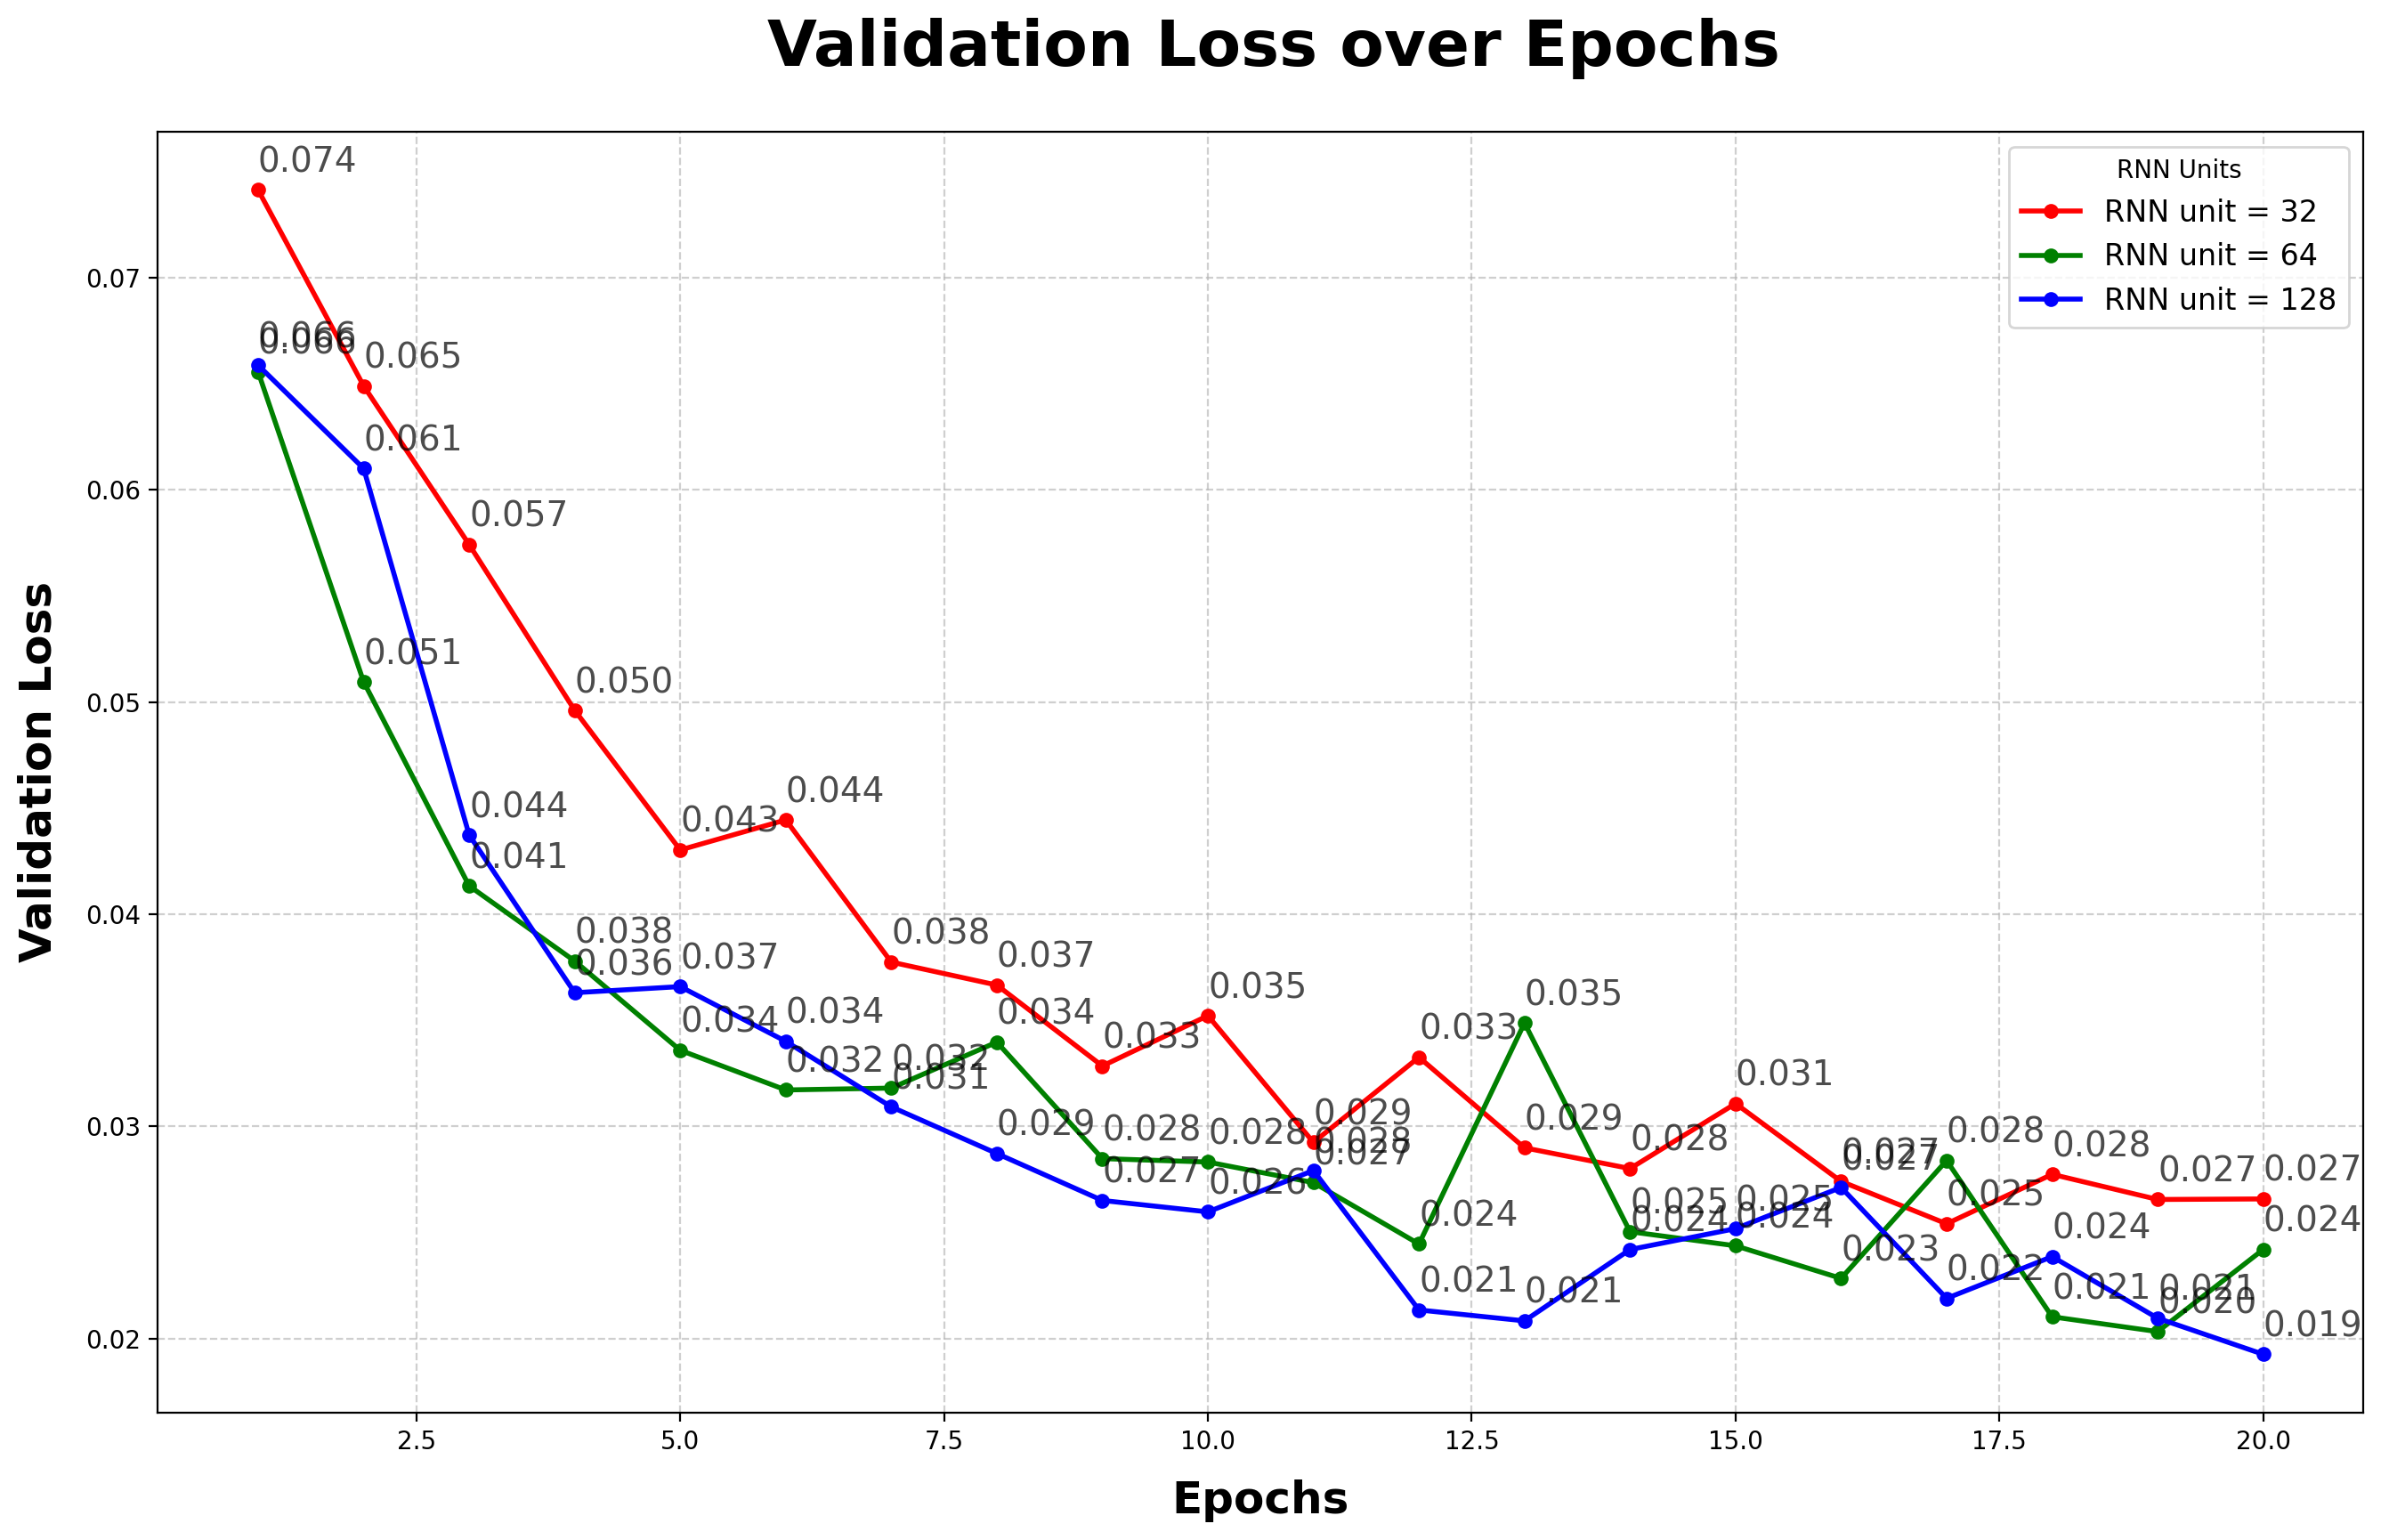

In [89]:
import matplotlib.pyplot as plt

# 색상 매핑
colors = dict(zip(rnn_units,['r','g','b']))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 10))

for rnn_unit in rnn_units:
    subset = df[df['rnn_unit'] == rnn_unit]
    subset = subset.sort_values('epoch')
    
    # 각 서브그래프의 최솟값 찾기
    min_loss = subset['valid_loss'].min()
    
    # 최솟값에 비례하는 색상 계산
    norm = plt.Normalize(vmin=0.02, vmax=0.05, clip=True)

    # 그래프 그리기 (각각의 RNN unit을 다른 색상으로 겹쳐서 표시)
    ax.plot(subset['epoch'], subset['valid_loss'], marker='o', linewidth=2, markersize=5, color=colors[rnn_unit], label=f"RNN unit = {rnn_unit}")
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # 각 포인트마다 값 표시
    for xi, yi in zip(subset['epoch'], subset['valid_loss']):
        ax.text(xi, yi+0.0005, f"{yi:.3f}", fontsize=14, color='black', ha='left', va='bottom', alpha=0.7)

# x축과 y축 라벨
ax.set_xlabel("Epochs", fontsize=18, weight='bold', labelpad=10)
ax.set_ylabel("Validation Loss", fontsize=18, weight='bold', labelpad=10)

# 범례 추가
ax.legend(title="RNN Units", fontsize=12)

# 전체 큰 제목
fig.suptitle("Validation Loss over Epochs", fontsize=26, weight='bold', x=0.58, y=0.93)

plt.tight_layout(rect=[0.1, 0.07, 1, 0.93])
plt.show()

### Experiment4 : Ablations

In [90]:
class BiLSTMOnly(nn.Module):
    def __init__(self, cnn_unit, fc_unit, rnn_unit):
        super().__init__()

        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            BiLSTM(fc_unit, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

        self.frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            BiLSTM(fc_unit, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
        mel = self.melspectrogram(audio)

        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.frame_stack(mel)  # (B, T, C)

        return frame_pred, onset_pred
      
      

class ConcatOnly(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        super().__init__()
        
        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.pre_frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.post_frame_stack = nn.Sequential(
            ConvStack(88*2, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
      
        mel = self.melspectrogram(audio)  # (B, T, F)
        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.pre_frame_stack(mel)
        frame_pred = torch.concat((frame_pred, onset_pred), dim=2)
        frame_pred = self.post_frame_stack(frame_pred)

        return frame_pred, onset_pred

In [93]:
batch_size = 16
iterations=3000
validation_interval=1000

sequence_length=51200
cnn_unit=48
fc_unit=128
rnn_units=128

learning_rate = 1e-3
weight_decay = 0.0

NUM_EPOCHS = 20

models = {
  'BasicOnsetsAndFrames': BasicOnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit),
  'BiLSTMOnly': BiLSTMOnly(cnn_unit=cnn_unit, fc_unit=fc_unit, rnn_unit=rnn_unit),
  'ConcatOnly': ConcatOnly(cnn_unit=cnn_unit, fc_unit=fc_unit),
  'OnsetsAndFrames': OnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit, rnn_unit=rnn_unit)
}

valid_losses4 = []
results4 = []

train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

for name, model in models.items():
  print(f"Training with model={name}")

  runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

  for epoch in range(NUM_EPOCHS):
    print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
    train_loss = runner.train(train_loader)
    valid_loss, result = runner.test(valid_loader)
    valid_losses4.append(valid_loss)
    results4.append(result)
  print()

import pickle
with open('valid_losses4.pkl', 'wb') as f:
    pickle.dump(valid_losses4, f)
with open('results4.pkl', 'wb') as f:
    pickle.dump(results4, f)

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train:   0%|          | 0/100 [00:00<?, ?it/s]

Loading group train:  64%|██████▍   | 64/100 [00:10<00:05,  6.36it/s]


KeyboardInterrupt: 

In [94]:
import pickle
with open('valid_losses4.pkl', 'rb') as f:
  valid_losses = pickle.load(f)
with open('results4.pkl', 'rb') as f:
  results = pickle.load(f)
  
import pandas as pd
from itertools import product
import numpy as np

models = ['BasicOnsetsAndFrames', 'BiLSTMOnly', 'ConcatOnly', 'OnsetsAndFrames']

NUM_EPOCHS = 20

df = pd.DataFrame(product(models, range(1,NUM_EPOCHS+1)), columns=['model', 'epoch'])
df['valid_loss'] = valid_losses
df = pd.concat([df, pd.DataFrame(results)],axis=1)
df

model  epoch  valid_loss metric/loss/frame_loss  \
0   BasicOnsetsAndFrames      1    0.035104           [0.07355176]   
1   BasicOnsetsAndFrames      2    0.032167           [0.06532537]   
2   BasicOnsetsAndFrames      3    0.025945          [0.053492907]   
3   BasicOnsetsAndFrames      4    0.026739           [0.05692138]   
4   BasicOnsetsAndFrames      5    0.026904          [0.056231987]   
..                   ...    ...         ...                    ...   
75       OnsetsAndFrames     16    0.020389          [0.040656384]   
76       OnsetsAndFrames     17    0.021204           [0.04258435]   
77       OnsetsAndFrames     18    0.019420          [0.039931733]   
78       OnsetsAndFrames     19    0.024259          [0.048145328]   
79       OnsetsAndFrames     20    0.020787          [0.037991125]   

   metric/loss/onset_loss                       metric/frame/frame_precision  \
0          [0.0034032573]  [0.6428571428571429, 0.8616352201257862, 0.914...   
1          [0.0027243127]  [0.8622754491017964, 0.8022222222222222, 0.869...   
2          [0.0026842123]  [0.9, 0.9836601307189542, 0.9247787610619469, ...   
3            [0.00245132]  [0.9010989010989011, 0.9878542510121457, 0.929...   
4          [0.0022921734]  [0.8176470588235294, 0.9528985507246377, 0.942...   
..                    ...                                                ...   
75         [0.0028901722]  [0.75, 0.8641975308641975, 0.865979381443299, ...   
76         [0.0029433216]  [0.728, 0.8127659574468085, 0.8317460317460318...   
77         [0.0029043825]  [0.7811158798283262, 0.8840970350404312, 0.923...   
78         [0.0030492626]  [0.5786666666666667, 0.7515400410677618, 0.825...   
79         [0.0029266593]  [0.7326007326007326, 0.8787128712871287, 0.874...   

                            metric/frame/frame_recall  \
0   [0.37388724035608306, 0.6171171171171171, 0.52...   
1   [0.42729970326409494, 0.8130630630630631, 0.68...   
2   [0.29376854599406527, 0.6779279279279279, 0.69...   
3   [0.2433234421364985, 0.5495495495495496, 0.609...   
4   [0.4124629080118694, 0.5923423423423423, 0.546...   
..                                                ...   
75  [0.44510385756676557, 0.7882882882882883, 0.83...   
76  [0.5400593471810089, 0.8603603603603603, 0.867...   
77  [0.5400593471810089, 0.7387387387387387, 0.877...   
78  [0.6439169139465876, 0.8243243243243243, 0.890...   
79  [0.5934718100890207, 0.7995495495495496, 0.874...   

                                metric/frame/frame_f1  \
0   [0.4727954971857411, 0.7191601049868765, 0.670...   
1   [0.5714285714285715, 0.8076062639821029, 0.766...   
2   [0.44295302013422816, 0.8026666666666666, 0.79...   
3   [0.38317757009345793, 0.7062228654124457, 0.73...   
4   [0.5483234714003944, 0.7305555555555555, 0.691...   
..                                                ...   
75  [0.5586592178770949, 0.8244994110718492, 0.849...   
76  [0.6201022146507665, 0.8358862144420129, 0.849...   
77  [0.6385964912280702, 0.8049079754601228, 0.899...   
78  [0.6095505617977529, 0.7862513426423201, 0.856...   
79  [0.6557377049180327, 0.8372641509433962, 0.874...   

                         metric/frame/onset_precision  \
0   [0.75, 0.7142857142857143, 0.8888888888888888,...   
1   [0.7777777777777778, 0.8888888888888888, 0.894...   
2   [0.6666666666666666, 0.875, 0.8947368421052632...   
3   [0.6363636363636364, 0.875, 0.9411764705882353...   
4   [0.6, 0.8461538461538461, 0.8947368421052632, ...   
..                                                ...   
75  [0.6818181818181818, 0.7368421052631579, 0.703...   
76  [0.6, 0.7777777777777778, 0.7916666666666666, ...   
77  [0.6521739130434783, 0.65, 0.8260869565217391,...   
78                            [0.6, 0.65, 0.75, 0.75]   
79  [0.625, 0.7368421052631579, 0.7916666666666666...   

                            metric/frame/onset_recall  \
0   [0.35294117647058826, 0.35714285714285715, 0.8...   
1   [0.4117647058823529, 0.5714285714285714, 0.8

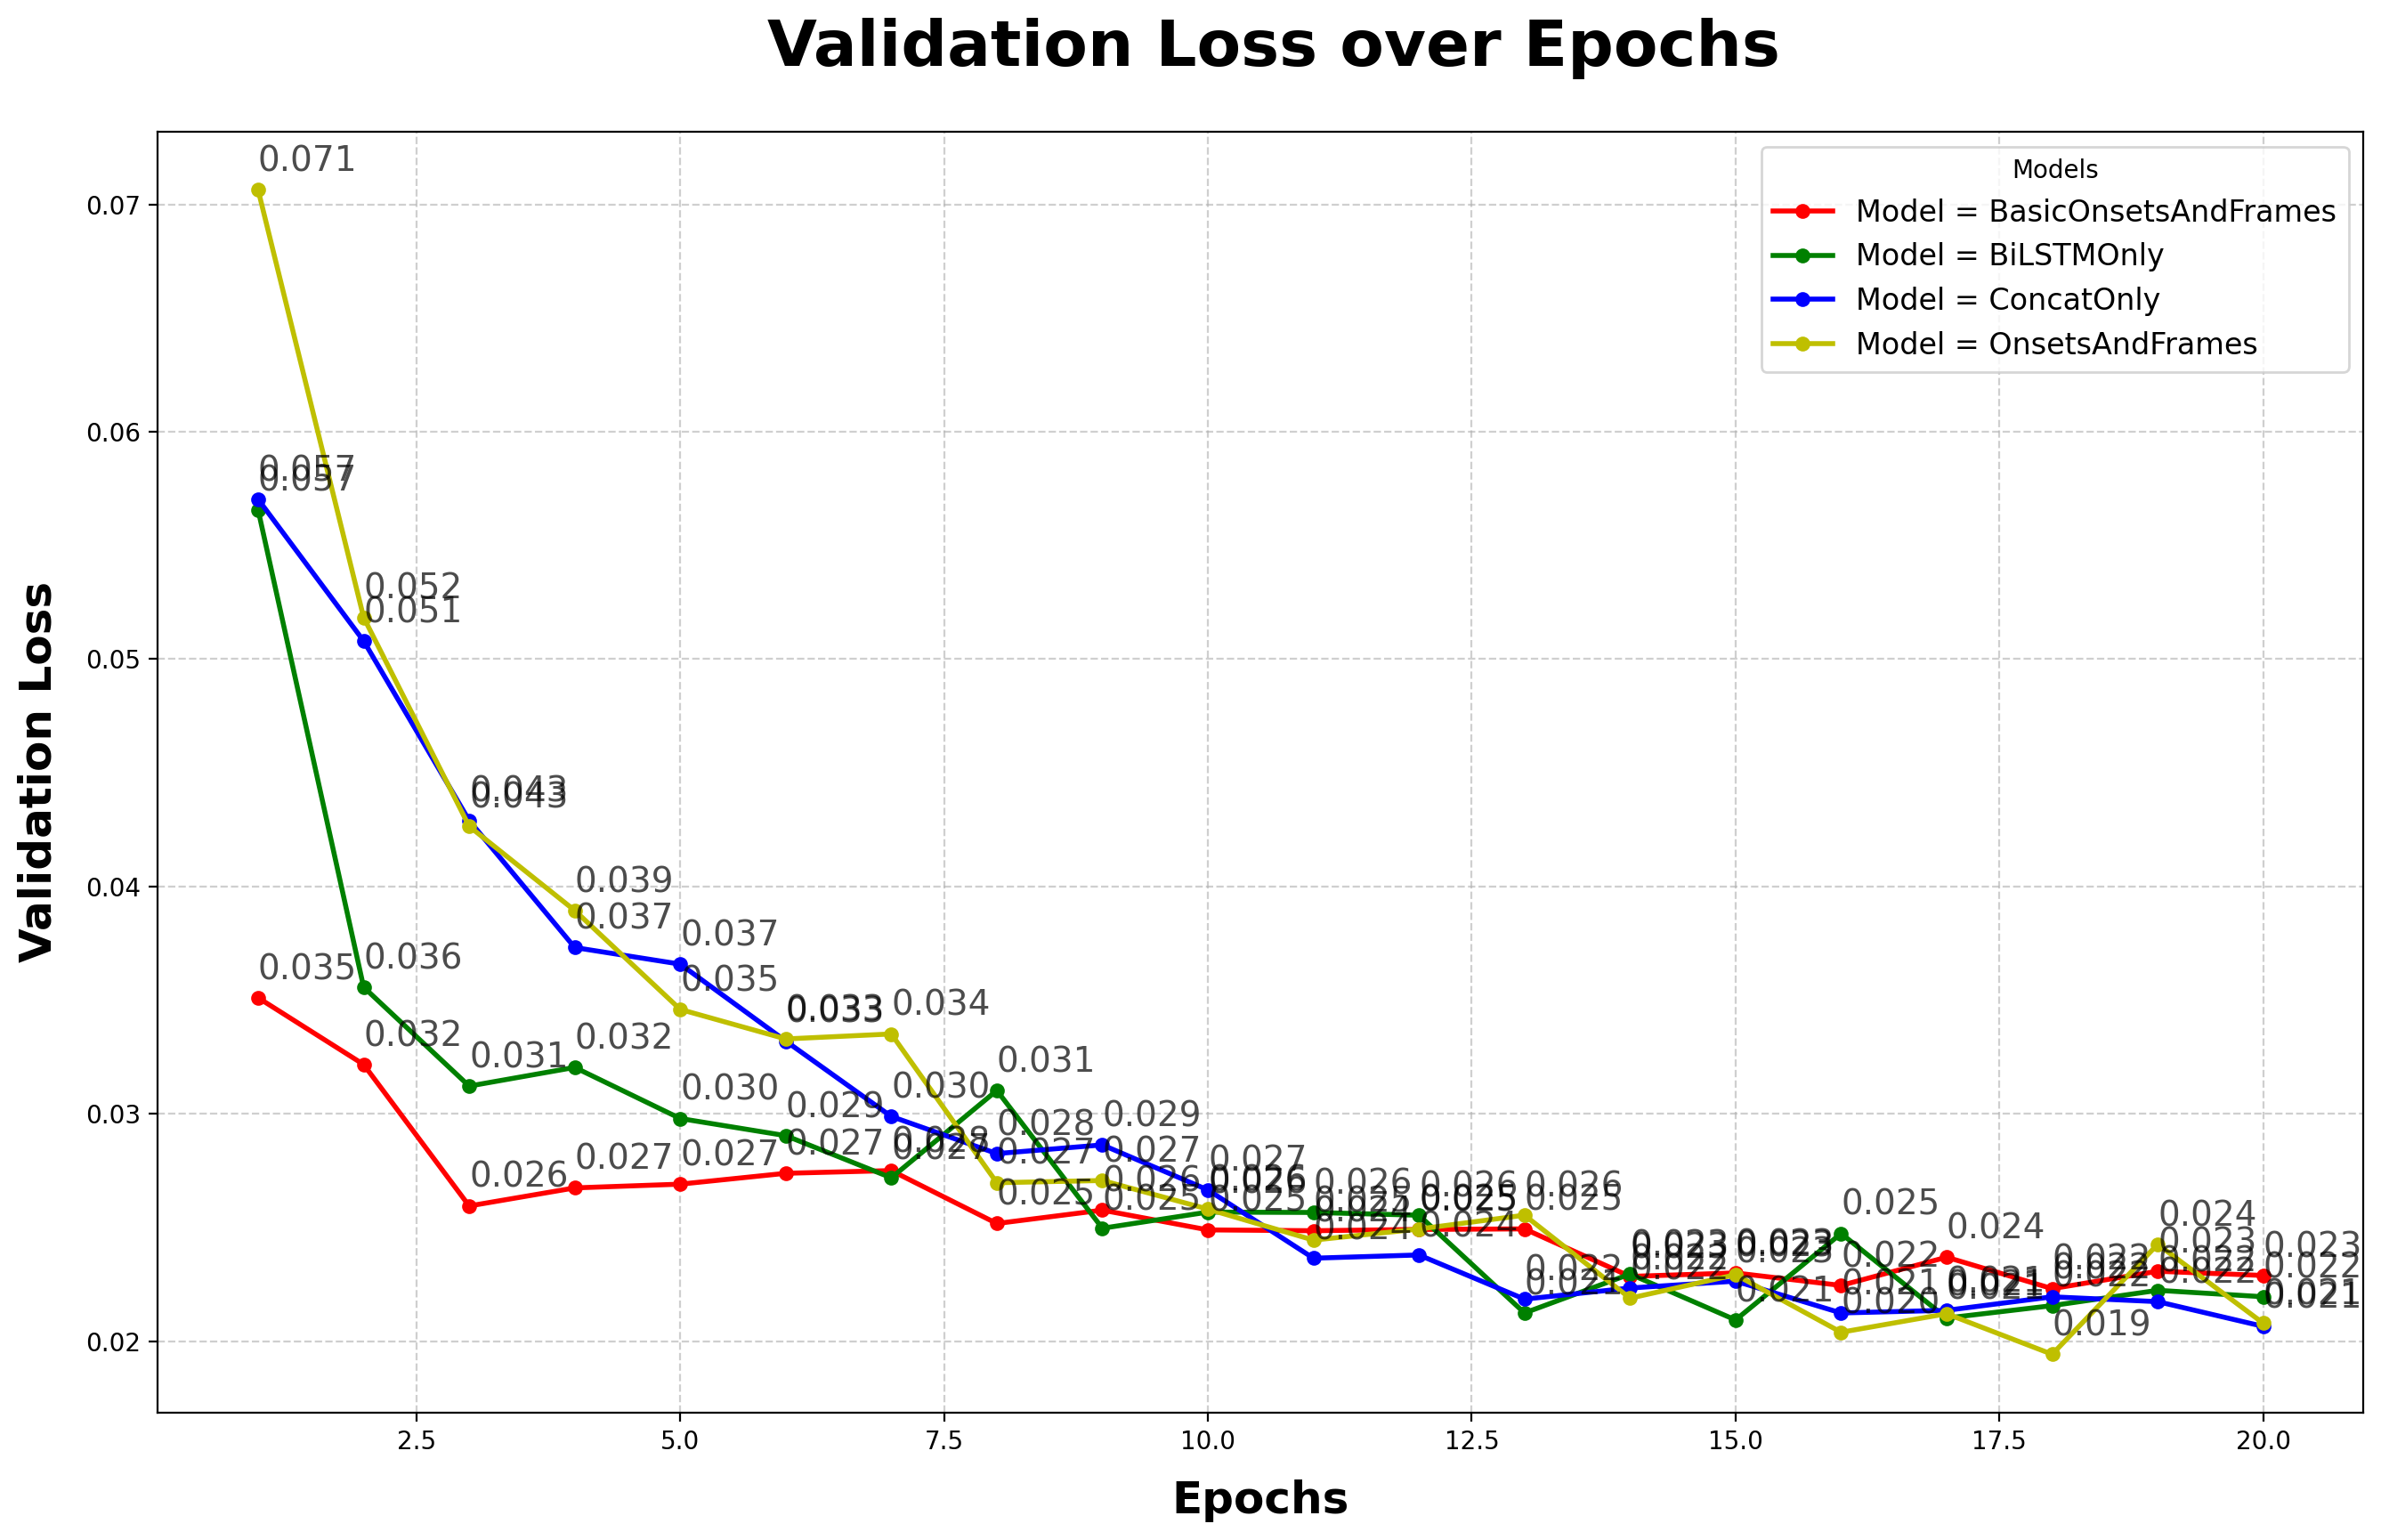

In [95]:
import matplotlib.pyplot as plt

# 색상 매핑
colors = dict(zip(models,['r','g','b','y']))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 10))

for model in models:
    subset = df[df['model'] == model]
    subset = subset.sort_values('epoch')
    
    # 각 서브그래프의 최솟값 찾기
    min_loss = subset['valid_loss'].min()
    
    # 최솟값에 비례하는 색상 계산
    norm = plt.Normalize(vmin=0.02, vmax=0.05, clip=True)

    # 그래프 그리기 (각각의 RNN unit을 다른 색상으로 겹쳐서 표시)
    ax.plot(subset['epoch'], subset['valid_loss'], marker='o', linewidth=2, markersize=5, color=colors[model], label=f"Model = {model}")
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # 각 포인트마다 값 표시
    for xi, yi in zip(subset['epoch'], subset['valid_loss']):
        ax.text(xi, yi+0.0005, f"{yi:.3f}", fontsize=14, color='black', ha='left', va='bottom', alpha=0.7)

# x축과 y축 라벨
ax.set_xlabel("Epochs", fontsize=18, weight='bold', labelpad=10)
ax.set_ylabel("Validation Loss", fontsize=18, weight='bold', labelpad=10)

# 범례 추가
ax.legend(title="Models", fontsize=12)

# 전체 큰 제목
fig.suptitle("Validation Loss over Epochs", fontsize=26, weight='bold', x=0.58, y=0.93)

plt.tight_layout(rect=[0.1, 0.07, 1, 0.93])
plt.show()

### Final Model


In [97]:
batch_size = 16
iterations=3000
validation_interval=1000

sequence_length=51200
cnn_unit=48
fc_unit=128
rnn_unit=128

learning_rate = 1e-3
weight_decay = 0.0

NUM_EPOCHS = 20

model = OnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit, rnn_unit=rnn_unit)

train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

for epoch in range(NUM_EPOCHS):
  print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
  train_loss = runner.train(train_loader)
  valid_loss, result = runner.test(valid_loader)

Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group train: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Loading 1 group(s) of MAESTRO_small at gct634-maestro


Loading group validation: 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


[Epoch 1/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.50it/s, loss: 2.179e-01]
/home/airis_lab/JL/GCT634/.venv/lib/python3.10/site-packages/mir_eval/transcription.py:163: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s, loss: 1.806e-01]


metric/frame/frame_f1       : 0.0189
metric/frame/onset_f1       : 0.5290
metric/note/f1              : 0.5886
metric/note-with-offsets/f1 : 0.0471
[Epoch 3/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.42it/s, loss: 1.521e-01]


metric/frame/frame_f1       : 0.1598
metric/frame/onset_f1       : 0.6718
metric/note/f1              : 0.7572
metric/note-with-offsets/f1 : 0.1051
[Epoch 4/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.42it/s, loss: 1.551e-01]


metric/frame/frame_f1       : 0.4473
metric/frame/onset_f1       : 0.6998
metric/note/f1              : 0.7953
metric/note-with-offsets/f1 : 0.1760
[Epoch 5/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.50it/s, loss: 1.523e-01]


metric/frame/frame_f1       : 0.5032
metric/frame/onset_f1       : 0.7207
metric/note/f1              : 0.8269
metric/note-with-offsets/f1 : 0.2928
[Epoch 6/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.56it/s, loss: 1.233e-01]


metric/frame/frame_f1       : 0.5776
metric/frame/onset_f1       : 0.7367
metric/note/f1              : 0.8346
metric/note-with-offsets/f1 : 0.2676
[Epoch 7/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s, loss: 1.236e-01]


metric/frame/frame_f1       : 0.6097
metric/frame/onset_f1       : 0.7178
metric/note/f1              : 0.8200
metric/note-with-offsets/f1 : 0.3113
[Epoch 8/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.52it/s, loss: 9.502e-02]


metric/frame/frame_f1       : 0.6644
metric/frame/onset_f1       : 0.7418
metric/note/f1              : 0.8511
metric/note-with-offsets/f1 : 0.3244
[Epoch 9/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s, loss: 1.010e-01]


metric/frame/frame_f1       : 0.6734
metric/frame/onset_f1       : 0.7451
metric/note/f1              : 0.8652
metric/note-with-offsets/f1 : 0.4084
[Epoch 10/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.49it/s, loss: 7.965e-02]


metric/frame/frame_f1       : 0.6974
metric/frame/onset_f1       : 0.7286
metric/note/f1              : 0.8421
metric/note-with-offsets/f1 : 0.3892
[Epoch 11/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.55it/s, loss: 8.757e-02]


metric/frame/frame_f1       : 0.6942
metric/frame/onset_f1       : 0.7355
metric/note/f1              : 0.8544
metric/note-with-offsets/f1 : 0.4224
[Epoch 12/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.58it/s, loss: 8.051e-02]


metric/frame/frame_f1       : 0.7113
metric/frame/onset_f1       : 0.7191
metric/note/f1              : 0.8469
metric/note-with-offsets/f1 : 0.4286
[Epoch 13/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s, loss: 7.674e-02]


metric/frame/frame_f1       : 0.7148
metric/frame/onset_f1       : 0.7431
metric/note/f1              : 0.8613
metric/note-with-offsets/f1 : 0.4327
[Epoch 14/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.48it/s, loss: 7.112e-02]


metric/frame/frame_f1       : 0.7131
metric/frame/onset_f1       : 0.7454
metric/note/f1              : 0.8751
metric/note-with-offsets/f1 : 0.4426
[Epoch 15/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s, loss: 9.766e-02]


metric/frame/frame_f1       : 0.7504
metric/frame/onset_f1       : 0.7599
metric/note/f1              : 0.8759
metric/note-with-offsets/f1 : 0.4749
[Epoch 16/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.48it/s, loss: 8.302e-02]


metric/frame/frame_f1       : 0.7518
metric/frame/onset_f1       : 0.7390
metric/note/f1              : 0.8692
metric/note-with-offsets/f1 : 0.4447
[Epoch 17/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s, loss: 7.135e-02]


metric/frame/frame_f1       : 0.7552
metric/frame/onset_f1       : 0.7440
metric/note/f1              : 0.8591
metric/note-with-offsets/f1 : 0.4389
[Epoch 18/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.55it/s, loss: 7.655e-02]


metric/frame/frame_f1       : 0.7306
metric/frame/onset_f1       : 0.7404
metric/note/f1              : 0.8713
metric/note-with-offsets/f1 : 0.4456
[Epoch 19/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s, loss: 1.015e-01]


metric/frame/frame_f1       : 0.7801
metric/frame/onset_f1       : 0.7533
metric/note/f1              : 0.8766
metric/note-with-offsets/f1 : 0.4615
[Epoch 20/20]


100%|██████████| 1000/1000 [00:39<00:00, 25.54it/s, loss: 7.353e-02]


metric/frame/frame_f1       : 0.7792
metric/frame/onset_f1       : 0.7199
metric/note/f1              : 0.8575
metric/note-with-offsets/f1 : 0.4210


## Transcribe a piece of piano recording

Let's transcribe a piano music piece using the trained model.

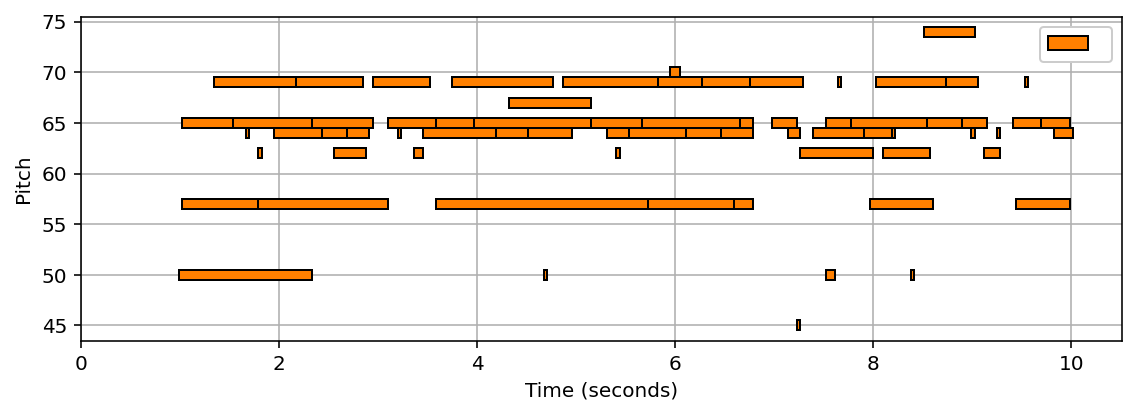

In [98]:
import math
import torch.nn.functional as F
from mir_eval.util import midi_to_hz


def save_midi(path, pitches, intervals, velocities):
    """Saves extracted notes as a MIDI file.

    Args:
        path: the path to save the MIDI file
        pitches: np.ndarray of bin_indices
        intervals: list of tuple (onset_index, offset_index)
        velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(
            dict(type='on',
                 pitch=pitches[i],
                 time=intervals[i][0],
                 velocity=velocities[i]))
        events.append(
            dict(type='off',
                 pitch=pitches[i],
                 time=intervals[i][1],
                 velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(
            Message('note_' + event['type'],
                    note=pitch,
                    velocity=velocity,
                    time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)


# We use the example piano piece at the beginning.
audio_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.flac'
audio, sr = soundfile.read(audio_file)
audio_seg = audio[:10*sr]

t_audio = torch.tensor(audio_seg).to(torch.float).to(runner.device)
pad_len = math.ceil(len(t_audio) / HOP_SIZE) * HOP_SIZE - len(t_audio)
t_audio = torch.unsqueeze(F.pad(t_audio, (0, pad_len)), 0)

frame_pred, onset_pred = model(t_audio)
p_est, i_est = extract_notes(onset_pred[0], frame_pred[0])

scaling = HOP_SIZE / SAMPLE_RATE
i_est = (i_est * scaling).reshape(-1, 2)
p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

midi_output_filename = 'output.midi'

save_midi(midi_output_filename, p_est, i_est, [64] * len(p_est))
midi_file = pretty_midi.PrettyMIDI(str(midi_output_filename))
synth_audio = midi_file.fluidsynth(fs=16000)


midi_score = libfmp.c1.midi_to_list(midi_output_filename)
libfmp.c1.visualize_piano_roll(midi_score, figsize=(8, 3))

ipd.Audio(synth_audio, rate=16000)


# Credit
This homework was implemented and improved by Taegyun Kwon and Juhan Nam from the KAIST Music and Audio Computing Lab.
